# Used Car Price Prediction Model Training

In [1]:
# General Library
import pandas as pd
import numpy as np
import datetime as dt
import warnings
import re
import matplotlib.pyplot as plt

#Pipline line library
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder,FunctionTransformer
from sklearn.pipeline import make_pipeline
import category_encoders as ce


#Machine Learning Library
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor,StackingRegressor, VotingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
import xgboost as xgb
import catboost as cb
import lightgbm as lgbm

#Evaluation Metrix and Hyperparameter tuning
from sklearn.metrics import mean_squared_error , r2_score

#Model save
import dill



warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
df=pd.read_csv('train-data.csv')
df.head()

,Sr No,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,NaN,1.75
1,1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN,12.50
2,2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh,4.50
3,3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN,6.00
4,4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN,17.74


# Data Preprocessing

<b> As per exploratory data analysis clean data and do feature engineering <b/>

In [3]:
# impute missing value

df['Seats']=df.Seats.replace(0,np.nan)
df['Power']=df.Power.replace("null bhp",np.nan)
df['Mileage']=df.Mileage.replace("0.0 kmpl",np.nan)


mp=SimpleImputer(missing_values=np.nan,strategy='most_frequent')


df[['Mileage','Engine','Power','Seats']]=mp.fit_transform(df[['Mileage','Engine','Power','Seats']])

df["Seats"]=pd.to_numeric(df.Seats)

In [4]:
#Extract numeric data from fetatures and create new features 

df["Brand_Name"]= df.Name.apply(lambda x: x.split()[0])

df['Mileage_unit']=[re.findall('[A-z/]+',str(k))[0] for k in df.Mileage]

for i in ["Engine","Power","Mileage"]:
    df[i]=df[i].apply(lambda x : pd.to_numeric(x.split()[0],errors='ignore'))
    
    
df["Brand_Name"]=df["Brand_Name"].replace("ISUZU",'Isuzu')  

<b> Drop Unwanted columns from dataset </b>

In [5]:
df.drop(["Sr No","Name","New_Price",'Kilometers_Driven'],axis=1,inplace=True)

In [6]:
df.head()

,Location,Year,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price,Brand_Name,Mileage_unit
0,Mumbai,2010,CNG,Manual,First,26.60,998,58.16,5.0,1.75,Maruti,km/kg
1,Pune,2015,Diesel,Manual,First,19.67,1582,126.20,5.0,12.50,Hyundai,kmpl
2,Chennai,2011,Petrol,Manual,First,18.20,1199,88.70,5.0,4.50,Honda,kmpl
3,Chennai,2012,Diesel,Manual,First,20.77,1248,88.76,7.0,6.00,Maruti,kmpl
4,Coimbatore,2013,Diesel,Automatic,Second,15.20,1968,140.80,5.0,17.74,Audi,kmpl


# Feature Engineering and Machine Learning Pipline

#### Split dependent and independent variable

In [7]:
# Define Depedant and indipedant variable
x=df.drop('Price',axis=1)
y=df.Price

In [8]:
#Create Pipeline

onhot=OneHotEncoder(drop ="if_binary")
target_en=ce.TargetEncoder()
Freq_en=ce.CountEncoder(normalize=True,min_group_size={"Brand_Name":0})
enc=OrdinalEncoder(categories=[["Fourth & Above","Third","Second","First"]])
sc=StandardScaler()
car_age=FunctionTransformer(lambda x: dt.date.today().year - x)

#column traansformer
CT=make_column_transformer((onhot,["Fuel_Type","Transmission","Mileage_unit"]),
                               (car_age,["Year"]),
                               (target_en,["Location"]),
                              (Freq_en,["Brand_Name"]),
                               (enc,['Owner_Type']),
                              remainder='passthrough')


def get_model():
    """ This function return list of mdoel"""
    models=[]
    models.append(("RandomForest",RandomForestRegressor(random_state=10)))
    models.append(("xgboost",xgb.XGBRegressor(random_state=10)))
    models.append(("Catboost",cb.CatBoostRegressor(loss_function="RMSE")))
    models.append(("Lightgbm",lgbm.LGBMRegressor()))
    models.append(("KNeighbors",KNeighborsRegressor()))
    models.append(("SVR",SVR()))
    return models




models={"RandomForest":RandomForestRegressor(random_state=10),
       "xgboost":xgb.XGBRegressor(random_state=10),
        "Catboost":cb.CatBoostRegressor(loss_function="RMSE"),
        "Lightgbm":lgbm.LGBMRegressor(),
        "KNeighbors":KNeighborsRegressor(),
       "SVR":SVR(),
       "VotingRegressor":VotingRegressor(get_model()),
       "StackingRegressor": StackingRegressor(estimators=get_model(), final_estimator=LinearRegression(), cv=5)}
    

In [9]:
CT.fit_transform(x,y)

array([[1.000e+00, 0.000e+00, 0.000e+00, ..., 9.980e+02, 5.816e+01,
        5.000e+00],
       [0.000e+00, 1.000e+00, 0.000e+00, ..., 1.582e+03, 1.262e+02,
        5.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 1.199e+03, 8.870e+01,
        5.000e+00],
       ...,
       [0.000e+00, 1.000e+00, 0.000e+00, ..., 2.498e+03, 1.120e+02,
        8.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 9.980e+02, 6.710e+01,
        5.000e+00],
       [0.000e+00, 1.000e+00, 0.000e+00, ..., 9.360e+02, 5.760e+01,
        5.000e+00]])

#### Create Machine Learning Pipeline

In [10]:
def Training(model,CT,x,y):
    """"This function train the mode and return 4 value
         1. RSME
         2. Train r2_score
         3. Test rs_score
         4. Variance
    model : Algorithms
    x : Dependent variable
    y : Independent variable"""
       
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
    
    pip=make_pipeline(CT,sc,model)
    pip.fit(x_train,y_train)
    y_pre=pip.predict(x_test)
    
    rsme=(np.sqrt(mean_squared_error(y_test, y_pre)))
    r2score=(r2_score(y_test, y_pre))
    TrainR2=pip.score(x_train,y_train)
    variance=TrainR2-r2score
    return rsme,r2score,TrainR2,variance


# Empty Dataframe for store evaluation matrix of different models
Model_Summary=pd.DataFrame(columns=["Model_name","Train r2_score","Test r2_score","RSME","Variance"])

<b> Model Training</b> 

In [11]:
for model in models:
    
    summary=Training(models[model],CT,x,y)
    
    Model_Summary=Model_Summary.append({"Model_name":model,"RSME":summary[0],
                                        "Test r2_score":summary[1],"Train r2_score":summary[2],
                                       "Variance":summary[3]},ignore_index=True)

Learning rate set to 0.051033
0:	learn: 10.9063701	total: 146ms	remaining: 2m 26s
1:	learn: 10.5220022	total: 149ms	remaining: 1m 14s
2:	learn: 10.1502013	total: 152ms	remaining: 50.6s
3:	learn: 9.8247733	total: 155ms	remaining: 38.7s
4:	learn: 9.5008102	total: 158ms	remaining: 31.5s
5:	learn: 9.1940266	total: 162ms	remaining: 26.8s
6:	learn: 8.9210447	total: 165ms	remaining: 23.4s
7:	learn: 8.6528634	total: 168ms	remaining: 20.8s
8:	learn: 8.3713615	total: 171ms	remaining: 18.8s
9:	learn: 8.1293846	total: 177ms	remaining: 17.5s
10:	learn: 7.8845578	total: 181ms	remaining: 16.2s
11:	learn: 7.6685136	total: 184ms	remaining: 15.1s
12:	learn: 7.4677346	total: 187ms	remaining: 14.2s
13:	learn: 7.2721510	total: 190ms	remaining: 13.4s
14:	learn: 7.0874332	total: 193ms	remaining: 12.7s
15:	learn: 6.9097099	total: 196ms	remaining: 12.1s
16:	learn: 6.7472005	total: 199ms	remaining: 11.5s
17:	learn: 6.5855351	total: 202ms	remaining: 11s
18:	learn: 6.4353923	total: 205ms	remaining: 10.6s
19:	lear

181:	learn: 2.9711271	total: 668ms	remaining: 3s
182:	learn: 2.9667168	total: 671ms	remaining: 3s
183:	learn: 2.9617565	total: 674ms	remaining: 2.99s
184:	learn: 2.9579094	total: 677ms	remaining: 2.98s
185:	learn: 2.9556029	total: 680ms	remaining: 2.97s
186:	learn: 2.9505003	total: 682ms	remaining: 2.97s
187:	learn: 2.9457846	total: 685ms	remaining: 2.96s
188:	learn: 2.9327065	total: 688ms	remaining: 2.95s
189:	learn: 2.9260742	total: 691ms	remaining: 2.94s
190:	learn: 2.9218850	total: 694ms	remaining: 2.94s
191:	learn: 2.9172831	total: 696ms	remaining: 2.93s
192:	learn: 2.9140114	total: 699ms	remaining: 2.92s
193:	learn: 2.9090674	total: 702ms	remaining: 2.92s
194:	learn: 2.9039774	total: 705ms	remaining: 2.91s
195:	learn: 2.9003015	total: 707ms	remaining: 2.9s
196:	learn: 2.8940976	total: 710ms	remaining: 2.89s
197:	learn: 2.8888731	total: 713ms	remaining: 2.89s
198:	learn: 2.8821935	total: 716ms	remaining: 2.88s
199:	learn: 2.8768843	total: 719ms	remaining: 2.87s
200:	learn: 2.87341

351:	learn: 2.2533905	total: 1.16s	remaining: 2.13s
352:	learn: 2.2510961	total: 1.16s	remaining: 2.13s
353:	learn: 2.2477722	total: 1.16s	remaining: 2.13s
354:	learn: 2.2446420	total: 1.17s	remaining: 2.12s
355:	learn: 2.2412974	total: 1.17s	remaining: 2.12s
356:	learn: 2.2387476	total: 1.17s	remaining: 2.11s
357:	learn: 2.2354442	total: 1.18s	remaining: 2.11s
358:	learn: 2.2325895	total: 1.18s	remaining: 2.1s
359:	learn: 2.2319720	total: 1.18s	remaining: 2.1s
360:	learn: 2.2289706	total: 1.18s	remaining: 2.1s
361:	learn: 2.2261611	total: 1.19s	remaining: 2.09s
362:	learn: 2.2203830	total: 1.19s	remaining: 2.09s
363:	learn: 2.2177370	total: 1.19s	remaining: 2.08s
364:	learn: 2.2166421	total: 1.2s	remaining: 2.08s
365:	learn: 2.2137719	total: 1.2s	remaining: 2.08s
366:	learn: 2.2118161	total: 1.2s	remaining: 2.07s
367:	learn: 2.2117342	total: 1.21s	remaining: 2.07s
368:	learn: 2.2095020	total: 1.21s	remaining: 2.06s
369:	learn: 2.2060235	total: 1.21s	remaining: 2.06s
370:	learn: 2.2034

519:	learn: 1.8785548	total: 1.65s	remaining: 1.52s
520:	learn: 1.8775927	total: 1.65s	remaining: 1.52s
521:	learn: 1.8754108	total: 1.66s	remaining: 1.51s
522:	learn: 1.8741817	total: 1.66s	remaining: 1.51s
523:	learn: 1.8734134	total: 1.66s	remaining: 1.51s
524:	learn: 1.8706301	total: 1.66s	remaining: 1.5s
525:	learn: 1.8694882	total: 1.67s	remaining: 1.5s
526:	learn: 1.8677480	total: 1.67s	remaining: 1.5s
527:	learn: 1.8666397	total: 1.67s	remaining: 1.49s
528:	learn: 1.8649091	total: 1.68s	remaining: 1.49s
529:	learn: 1.8636739	total: 1.68s	remaining: 1.49s
530:	learn: 1.8617544	total: 1.68s	remaining: 1.48s
531:	learn: 1.8601748	total: 1.68s	remaining: 1.48s
532:	learn: 1.8571580	total: 1.69s	remaining: 1.48s
533:	learn: 1.8568465	total: 1.69s	remaining: 1.47s
534:	learn: 1.8557418	total: 1.69s	remaining: 1.47s
535:	learn: 1.8541587	total: 1.7s	remaining: 1.47s
536:	learn: 1.8520421	total: 1.7s	remaining: 1.47s
537:	learn: 1.8493660	total: 1.7s	remaining: 1.46s
538:	learn: 1.8483

686:	learn: 1.6561467	total: 2.14s	remaining: 974ms
687:	learn: 1.6555923	total: 2.14s	remaining: 971ms
688:	learn: 1.6551582	total: 2.14s	remaining: 968ms
689:	learn: 1.6543468	total: 2.15s	remaining: 964ms
690:	learn: 1.6542929	total: 2.15s	remaining: 961ms
691:	learn: 1.6535181	total: 2.15s	remaining: 958ms
692:	learn: 1.6526677	total: 2.15s	remaining: 955ms
693:	learn: 1.6512512	total: 2.16s	remaining: 951ms
694:	learn: 1.6496772	total: 2.16s	remaining: 948ms
695:	learn: 1.6492603	total: 2.16s	remaining: 945ms
696:	learn: 1.6484873	total: 2.17s	remaining: 942ms
697:	learn: 1.6476271	total: 2.17s	remaining: 939ms
698:	learn: 1.6467197	total: 2.17s	remaining: 936ms
699:	learn: 1.6463257	total: 2.17s	remaining: 932ms
700:	learn: 1.6459189	total: 2.18s	remaining: 929ms
701:	learn: 1.6453605	total: 2.18s	remaining: 926ms
702:	learn: 1.6440805	total: 2.18s	remaining: 923ms
703:	learn: 1.6436349	total: 2.19s	remaining: 919ms
704:	learn: 1.6430143	total: 2.19s	remaining: 916ms
705:	learn: 

846:	learn: 1.5077930	total: 2.63s	remaining: 474ms
847:	learn: 1.5069159	total: 2.63s	remaining: 471ms
848:	learn: 1.5060621	total: 2.63s	remaining: 469ms
849:	learn: 1.5052396	total: 2.64s	remaining: 465ms
850:	learn: 1.5042442	total: 2.64s	remaining: 462ms
851:	learn: 1.5029239	total: 2.64s	remaining: 459ms
852:	learn: 1.5018921	total: 2.65s	remaining: 456ms
853:	learn: 1.5011546	total: 2.65s	remaining: 453ms
854:	learn: 1.5000495	total: 2.65s	remaining: 450ms
855:	learn: 1.4992357	total: 2.66s	remaining: 448ms
856:	learn: 1.4977514	total: 2.67s	remaining: 445ms
857:	learn: 1.4963029	total: 2.67s	remaining: 442ms
858:	learn: 1.4960034	total: 2.68s	remaining: 440ms
859:	learn: 1.4948271	total: 2.68s	remaining: 437ms
860:	learn: 1.4940559	total: 2.68s	remaining: 433ms
861:	learn: 1.4930498	total: 2.69s	remaining: 430ms
862:	learn: 1.4919179	total: 2.69s	remaining: 427ms
863:	learn: 1.4909726	total: 2.69s	remaining: 424ms
864:	learn: 1.4907730	total: 2.7s	remaining: 421ms
865:	learn: 1

49:	learn: 4.1926521	total: 159ms	remaining: 3.02s
50:	learn: 4.1616927	total: 162ms	remaining: 3.01s
51:	learn: 4.1344927	total: 165ms	remaining: 3s
52:	learn: 4.1088944	total: 167ms	remaining: 2.99s
53:	learn: 4.0844398	total: 170ms	remaining: 2.98s
54:	learn: 4.0566823	total: 173ms	remaining: 2.97s
55:	learn: 4.0325698	total: 176ms	remaining: 2.96s
56:	learn: 4.0097394	total: 178ms	remaining: 2.95s
57:	learn: 3.9932208	total: 181ms	remaining: 2.94s
58:	learn: 3.9685698	total: 184ms	remaining: 2.93s
59:	learn: 3.9421542	total: 187ms	remaining: 2.93s
60:	learn: 3.9278849	total: 190ms	remaining: 2.92s
61:	learn: 3.9199317	total: 193ms	remaining: 2.91s
62:	learn: 3.9040724	total: 195ms	remaining: 2.91s
63:	learn: 3.8860931	total: 198ms	remaining: 2.9s
64:	learn: 3.8617532	total: 201ms	remaining: 2.89s
65:	learn: 3.8443959	total: 204ms	remaining: 2.88s
66:	learn: 3.8332826	total: 206ms	remaining: 2.87s
67:	learn: 3.8118257	total: 209ms	remaining: 2.86s
68:	learn: 3.7974553	total: 211ms	r

224:	learn: 2.7258560	total: 645ms	remaining: 2.22s
225:	learn: 2.7197413	total: 648ms	remaining: 2.22s
226:	learn: 2.7121308	total: 651ms	remaining: 2.21s
227:	learn: 2.7064153	total: 654ms	remaining: 2.21s
228:	learn: 2.7013244	total: 657ms	remaining: 2.21s
229:	learn: 2.6992676	total: 659ms	remaining: 2.21s
230:	learn: 2.6932656	total: 662ms	remaining: 2.2s
231:	learn: 2.6920774	total: 664ms	remaining: 2.2s
232:	learn: 2.6901718	total: 666ms	remaining: 2.19s
233:	learn: 2.6822135	total: 669ms	remaining: 2.19s
234:	learn: 2.6754326	total: 672ms	remaining: 2.19s
235:	learn: 2.6692385	total: 675ms	remaining: 2.18s
236:	learn: 2.6628311	total: 678ms	remaining: 2.18s
237:	learn: 2.6569229	total: 680ms	remaining: 2.18s
238:	learn: 2.6506538	total: 683ms	remaining: 2.17s
239:	learn: 2.6500605	total: 686ms	remaining: 2.17s
240:	learn: 2.6467064	total: 689ms	remaining: 2.17s
241:	learn: 2.6400497	total: 691ms	remaining: 2.17s
242:	learn: 2.6326881	total: 694ms	remaining: 2.16s
243:	learn: 2.

403:	learn: 2.1130109	total: 1.14s	remaining: 1.68s
404:	learn: 2.1088833	total: 1.14s	remaining: 1.68s
405:	learn: 2.1050718	total: 1.14s	remaining: 1.67s
406:	learn: 2.1012366	total: 1.15s	remaining: 1.67s
407:	learn: 2.0989641	total: 1.15s	remaining: 1.67s
408:	learn: 2.0963001	total: 1.15s	remaining: 1.66s
409:	learn: 2.0934862	total: 1.15s	remaining: 1.66s
410:	learn: 2.0920335	total: 1.16s	remaining: 1.66s
411:	learn: 2.0902621	total: 1.16s	remaining: 1.66s
412:	learn: 2.0872723	total: 1.16s	remaining: 1.65s
413:	learn: 2.0849304	total: 1.17s	remaining: 1.65s
414:	learn: 2.0815345	total: 1.17s	remaining: 1.65s
415:	learn: 2.0783237	total: 1.17s	remaining: 1.64s
416:	learn: 2.0761962	total: 1.17s	remaining: 1.64s
417:	learn: 2.0740289	total: 1.18s	remaining: 1.64s
418:	learn: 2.0703615	total: 1.18s	remaining: 1.64s
419:	learn: 2.0665853	total: 1.18s	remaining: 1.63s
420:	learn: 2.0638737	total: 1.19s	remaining: 1.63s
421:	learn: 2.0619172	total: 1.19s	remaining: 1.63s
422:	learn: 

576:	learn: 1.7902138	total: 1.63s	remaining: 1.19s
577:	learn: 1.7887331	total: 1.63s	remaining: 1.19s
578:	learn: 1.7878743	total: 1.64s	remaining: 1.19s
579:	learn: 1.7852923	total: 1.64s	remaining: 1.19s
580:	learn: 1.7841619	total: 1.64s	remaining: 1.18s
581:	learn: 1.7833707	total: 1.65s	remaining: 1.18s
582:	learn: 1.7815657	total: 1.65s	remaining: 1.18s
583:	learn: 1.7797257	total: 1.65s	remaining: 1.18s
584:	learn: 1.7765157	total: 1.65s	remaining: 1.17s
585:	learn: 1.7748615	total: 1.66s	remaining: 1.17s
586:	learn: 1.7722858	total: 1.66s	remaining: 1.17s
587:	learn: 1.7712010	total: 1.66s	remaining: 1.17s
588:	learn: 1.7703210	total: 1.67s	remaining: 1.16s
589:	learn: 1.7690055	total: 1.67s	remaining: 1.16s
590:	learn: 1.7674938	total: 1.67s	remaining: 1.16s
591:	learn: 1.7661301	total: 1.68s	remaining: 1.16s
592:	learn: 1.7636194	total: 1.68s	remaining: 1.15s
593:	learn: 1.7627369	total: 1.68s	remaining: 1.15s
594:	learn: 1.7612004	total: 1.69s	remaining: 1.15s
595:	learn: 

739:	learn: 1.6054954	total: 2.12s	remaining: 744ms
740:	learn: 1.6032854	total: 2.12s	remaining: 741ms
741:	learn: 1.6024753	total: 2.12s	remaining: 738ms
742:	learn: 1.6019034	total: 2.12s	remaining: 735ms
743:	learn: 1.6013250	total: 2.13s	remaining: 732ms
744:	learn: 1.5999366	total: 2.13s	remaining: 729ms
745:	learn: 1.5989909	total: 2.13s	remaining: 726ms
746:	learn: 1.5980864	total: 2.14s	remaining: 724ms
747:	learn: 1.5970366	total: 2.14s	remaining: 721ms
748:	learn: 1.5960369	total: 2.14s	remaining: 718ms
749:	learn: 1.5951533	total: 2.15s	remaining: 715ms
750:	learn: 1.5943300	total: 2.15s	remaining: 712ms
751:	learn: 1.5923048	total: 2.15s	remaining: 709ms
752:	learn: 1.5914773	total: 2.15s	remaining: 707ms
753:	learn: 1.5907652	total: 2.16s	remaining: 704ms
754:	learn: 1.5906536	total: 2.16s	remaining: 701ms
755:	learn: 1.5895272	total: 2.16s	remaining: 698ms
756:	learn: 1.5887476	total: 2.17s	remaining: 695ms
757:	learn: 1.5887129	total: 2.17s	remaining: 692ms
758:	learn: 

911:	learn: 1.4515144	total: 2.6s	remaining: 251ms
912:	learn: 1.4509890	total: 2.61s	remaining: 249ms
913:	learn: 1.4503722	total: 2.61s	remaining: 246ms
914:	learn: 1.4492135	total: 2.61s	remaining: 243ms
915:	learn: 1.4484759	total: 2.62s	remaining: 240ms
916:	learn: 1.4474867	total: 2.62s	remaining: 237ms
917:	learn: 1.4465624	total: 2.62s	remaining: 234ms
918:	learn: 1.4462221	total: 2.63s	remaining: 231ms
919:	learn: 1.4457438	total: 2.63s	remaining: 229ms
920:	learn: 1.4451996	total: 2.63s	remaining: 226ms
921:	learn: 1.4449504	total: 2.63s	remaining: 223ms
922:	learn: 1.4438860	total: 2.64s	remaining: 220ms
923:	learn: 1.4433987	total: 2.64s	remaining: 217ms
924:	learn: 1.4428298	total: 2.64s	remaining: 214ms
925:	learn: 1.4424496	total: 2.65s	remaining: 211ms
926:	learn: 1.4417160	total: 2.65s	remaining: 209ms
927:	learn: 1.4405485	total: 2.65s	remaining: 206ms
928:	learn: 1.4391738	total: 2.65s	remaining: 203ms
929:	learn: 1.4375885	total: 2.66s	remaining: 200ms
930:	learn: 1

116:	learn: 3.3700474	total: 325ms	remaining: 2.46s
117:	learn: 3.3630152	total: 328ms	remaining: 2.45s
118:	learn: 3.3586338	total: 331ms	remaining: 2.45s
119:	learn: 3.3527905	total: 334ms	remaining: 2.45s
120:	learn: 3.3473754	total: 337ms	remaining: 2.44s
121:	learn: 3.3380488	total: 340ms	remaining: 2.44s
122:	learn: 3.3325028	total: 342ms	remaining: 2.44s
123:	learn: 3.3269251	total: 345ms	remaining: 2.44s
124:	learn: 3.3231641	total: 347ms	remaining: 2.43s
125:	learn: 3.3120389	total: 350ms	remaining: 2.43s
126:	learn: 3.2997491	total: 353ms	remaining: 2.43s
127:	learn: 3.2943774	total: 356ms	remaining: 2.42s
128:	learn: 3.2885764	total: 358ms	remaining: 2.42s
129:	learn: 3.2849797	total: 361ms	remaining: 2.42s
130:	learn: 3.2801441	total: 364ms	remaining: 2.41s
131:	learn: 3.2694653	total: 367ms	remaining: 2.41s
132:	learn: 3.2648968	total: 369ms	remaining: 2.41s
133:	learn: 3.2519668	total: 372ms	remaining: 2.4s
134:	learn: 3.2423321	total: 375ms	remaining: 2.4s
135:	learn: 3.

295:	learn: 2.4217515	total: 825ms	remaining: 1.96s
296:	learn: 2.4210421	total: 827ms	remaining: 1.96s
297:	learn: 2.4158391	total: 830ms	remaining: 1.95s
298:	learn: 2.4148277	total: 832ms	remaining: 1.95s
299:	learn: 2.4098490	total: 835ms	remaining: 1.95s
300:	learn: 2.4055574	total: 838ms	remaining: 1.95s
301:	learn: 2.4021268	total: 841ms	remaining: 1.94s
302:	learn: 2.3996408	total: 844ms	remaining: 1.94s
303:	learn: 2.3992091	total: 846ms	remaining: 1.94s
304:	learn: 2.3966668	total: 849ms	remaining: 1.94s
305:	learn: 2.3960861	total: 852ms	remaining: 1.93s
306:	learn: 2.3956846	total: 854ms	remaining: 1.93s
307:	learn: 2.3955693	total: 857ms	remaining: 1.92s
308:	learn: 2.3906644	total: 860ms	remaining: 1.92s
309:	learn: 2.3883655	total: 862ms	remaining: 1.92s
310:	learn: 2.3832637	total: 865ms	remaining: 1.92s
311:	learn: 2.3785574	total: 868ms	remaining: 1.91s
312:	learn: 2.3729884	total: 871ms	remaining: 1.91s
313:	learn: 2.3726903	total: 873ms	remaining: 1.91s
314:	learn: 

472:	learn: 1.9587037	total: 1.32s	remaining: 1.47s
473:	learn: 1.9567109	total: 1.32s	remaining: 1.47s
474:	learn: 1.9558716	total: 1.32s	remaining: 1.46s
475:	learn: 1.9534895	total: 1.33s	remaining: 1.46s
476:	learn: 1.9523024	total: 1.33s	remaining: 1.46s
477:	learn: 1.9516989	total: 1.33s	remaining: 1.45s
478:	learn: 1.9487915	total: 1.33s	remaining: 1.45s
479:	learn: 1.9469343	total: 1.34s	remaining: 1.45s
480:	learn: 1.9462787	total: 1.34s	remaining: 1.45s
481:	learn: 1.9449154	total: 1.34s	remaining: 1.44s
482:	learn: 1.9429844	total: 1.35s	remaining: 1.44s
483:	learn: 1.9410970	total: 1.35s	remaining: 1.44s
484:	learn: 1.9403404	total: 1.35s	remaining: 1.44s
485:	learn: 1.9386324	total: 1.35s	remaining: 1.43s
486:	learn: 1.9374246	total: 1.36s	remaining: 1.43s
487:	learn: 1.9367801	total: 1.36s	remaining: 1.43s
488:	learn: 1.9349373	total: 1.36s	remaining: 1.42s
489:	learn: 1.9322922	total: 1.37s	remaining: 1.42s
490:	learn: 1.9300696	total: 1.37s	remaining: 1.42s
491:	learn: 

647:	learn: 1.7010335	total: 1.81s	remaining: 986ms
648:	learn: 1.7005144	total: 1.82s	remaining: 984ms
649:	learn: 1.6994619	total: 1.82s	remaining: 981ms
650:	learn: 1.6979460	total: 1.82s	remaining: 978ms
651:	learn: 1.6969302	total: 1.83s	remaining: 975ms
652:	learn: 1.6959223	total: 1.83s	remaining: 973ms
653:	learn: 1.6951177	total: 1.83s	remaining: 970ms
654:	learn: 1.6941882	total: 1.83s	remaining: 967ms
655:	learn: 1.6930579	total: 1.84s	remaining: 964ms
656:	learn: 1.6922713	total: 1.84s	remaining: 961ms
657:	learn: 1.6916711	total: 1.84s	remaining: 959ms
658:	learn: 1.6916166	total: 1.85s	remaining: 956ms
659:	learn: 1.6905909	total: 1.85s	remaining: 953ms
660:	learn: 1.6895114	total: 1.85s	remaining: 950ms
661:	learn: 1.6882225	total: 1.85s	remaining: 947ms
662:	learn: 1.6867085	total: 1.86s	remaining: 944ms
663:	learn: 1.6860105	total: 1.86s	remaining: 942ms
664:	learn: 1.6852286	total: 1.86s	remaining: 939ms
665:	learn: 1.6833225	total: 1.87s	remaining: 936ms
666:	learn: 

827:	learn: 1.5229263	total: 2.31s	remaining: 481ms
828:	learn: 1.5223194	total: 2.32s	remaining: 478ms
829:	learn: 1.5214668	total: 2.32s	remaining: 475ms
830:	learn: 1.5200413	total: 2.32s	remaining: 472ms
831:	learn: 1.5191987	total: 2.33s	remaining: 470ms
832:	learn: 1.5186905	total: 2.33s	remaining: 467ms
833:	learn: 1.5179421	total: 2.33s	remaining: 464ms
834:	learn: 1.5173768	total: 2.33s	remaining: 461ms
835:	learn: 1.5159726	total: 2.34s	remaining: 458ms
836:	learn: 1.5159238	total: 2.34s	remaining: 455ms
837:	learn: 1.5149564	total: 2.34s	remaining: 453ms
838:	learn: 1.5145030	total: 2.34s	remaining: 450ms
839:	learn: 1.5133691	total: 2.35s	remaining: 447ms
840:	learn: 1.5127187	total: 2.35s	remaining: 444ms
841:	learn: 1.5112971	total: 2.35s	remaining: 441ms
842:	learn: 1.5106250	total: 2.35s	remaining: 439ms
843:	learn: 1.5101934	total: 2.36s	remaining: 436ms
844:	learn: 1.5095508	total: 2.36s	remaining: 433ms
845:	learn: 1.5086950	total: 2.36s	remaining: 430ms
846:	learn: 

Learning rate set to 0.049264
0:	learn: 11.1432392	total: 19.9ms	remaining: 19.9s
1:	learn: 10.7731297	total: 23ms	remaining: 11.5s
2:	learn: 10.4261272	total: 25.9ms	remaining: 8.59s
3:	learn: 10.0911693	total: 28.6ms	remaining: 7.13s
4:	learn: 9.7713428	total: 31.4ms	remaining: 6.25s
5:	learn: 9.4643446	total: 34.4ms	remaining: 5.69s
6:	learn: 9.1809368	total: 37.2ms	remaining: 5.28s
7:	learn: 8.9210428	total: 40.1ms	remaining: 4.98s
8:	learn: 8.6376421	total: 42.9ms	remaining: 4.72s
9:	learn: 8.3814371	total: 46ms	remaining: 4.55s
10:	learn: 8.1477808	total: 50.1ms	remaining: 4.5s
11:	learn: 7.9270607	total: 54.3ms	remaining: 4.47s
12:	learn: 7.7181913	total: 57.5ms	remaining: 4.37s
13:	learn: 7.5126404	total: 63.3ms	remaining: 4.46s
14:	learn: 7.3131991	total: 71.3ms	remaining: 4.68s
15:	learn: 7.1332624	total: 80.8ms	remaining: 4.97s
16:	learn: 6.9633475	total: 88.8ms	remaining: 5.13s
17:	learn: 6.8042615	total: 93.4ms	remaining: 5.09s
18:	learn: 6.6498944	total: 100ms	remaining: 

209:	learn: 2.8653092	total: 648ms	remaining: 2.44s
210:	learn: 2.8565658	total: 650ms	remaining: 2.43s
211:	learn: 2.8500386	total: 653ms	remaining: 2.43s
212:	learn: 2.8434029	total: 656ms	remaining: 2.42s
213:	learn: 2.8349296	total: 658ms	remaining: 2.42s
214:	learn: 2.8262927	total: 661ms	remaining: 2.41s
215:	learn: 2.8221879	total: 664ms	remaining: 2.41s
216:	learn: 2.8140240	total: 666ms	remaining: 2.4s
217:	learn: 2.8058231	total: 669ms	remaining: 2.4s
218:	learn: 2.7981732	total: 671ms	remaining: 2.39s
219:	learn: 2.7954342	total: 674ms	remaining: 2.39s
220:	learn: 2.7882339	total: 677ms	remaining: 2.38s
221:	learn: 2.7816742	total: 679ms	remaining: 2.38s
222:	learn: 2.7768383	total: 682ms	remaining: 2.38s
223:	learn: 2.7740232	total: 685ms	remaining: 2.37s
224:	learn: 2.7714169	total: 687ms	remaining: 2.37s
225:	learn: 2.7649002	total: 690ms	remaining: 2.36s
226:	learn: 2.7575014	total: 693ms	remaining: 2.36s
227:	learn: 2.7518736	total: 695ms	remaining: 2.35s
228:	learn: 2.

389:	learn: 2.1809912	total: 1.13s	remaining: 1.77s
390:	learn: 2.1792920	total: 1.14s	remaining: 1.77s
391:	learn: 2.1787338	total: 1.14s	remaining: 1.76s
392:	learn: 2.1738555	total: 1.14s	remaining: 1.76s
393:	learn: 2.1722003	total: 1.14s	remaining: 1.76s
394:	learn: 2.1669820	total: 1.15s	remaining: 1.76s
395:	learn: 2.1668837	total: 1.15s	remaining: 1.75s
396:	learn: 2.1631743	total: 1.15s	remaining: 1.75s
397:	learn: 2.1614278	total: 1.15s	remaining: 1.75s
398:	learn: 2.1601504	total: 1.16s	remaining: 1.74s
399:	learn: 2.1577903	total: 1.16s	remaining: 1.74s
400:	learn: 2.1552499	total: 1.16s	remaining: 1.74s
401:	learn: 2.1518552	total: 1.17s	remaining: 1.73s
402:	learn: 2.1503924	total: 1.17s	remaining: 1.73s
403:	learn: 2.1483449	total: 1.17s	remaining: 1.73s
404:	learn: 2.1434749	total: 1.17s	remaining: 1.72s
405:	learn: 2.1411088	total: 1.18s	remaining: 1.72s
406:	learn: 2.1396586	total: 1.18s	remaining: 1.72s
407:	learn: 2.1391511	total: 1.18s	remaining: 1.71s
408:	learn: 

549:	learn: 1.8531336	total: 1.62s	remaining: 1.32s
550:	learn: 1.8520353	total: 1.62s	remaining: 1.32s
551:	learn: 1.8496733	total: 1.63s	remaining: 1.32s
552:	learn: 1.8464895	total: 1.63s	remaining: 1.32s
553:	learn: 1.8446982	total: 1.63s	remaining: 1.31s
554:	learn: 1.8433886	total: 1.63s	remaining: 1.31s
555:	learn: 1.8410167	total: 1.64s	remaining: 1.31s
556:	learn: 1.8390821	total: 1.64s	remaining: 1.3s
557:	learn: 1.8362085	total: 1.64s	remaining: 1.3s
558:	learn: 1.8350747	total: 1.65s	remaining: 1.3s
559:	learn: 1.8328956	total: 1.65s	remaining: 1.3s
560:	learn: 1.8311269	total: 1.65s	remaining: 1.29s
561:	learn: 1.8295995	total: 1.66s	remaining: 1.29s
562:	learn: 1.8274605	total: 1.66s	remaining: 1.29s
563:	learn: 1.8264414	total: 1.66s	remaining: 1.28s
564:	learn: 1.8252445	total: 1.67s	remaining: 1.28s
565:	learn: 1.8230430	total: 1.67s	remaining: 1.28s
566:	learn: 1.8222214	total: 1.67s	remaining: 1.28s
567:	learn: 1.8202601	total: 1.68s	remaining: 1.27s
568:	learn: 1.81

711:	learn: 1.6042478	total: 2.1s	remaining: 849ms
712:	learn: 1.6037950	total: 2.1s	remaining: 846ms
713:	learn: 1.6026553	total: 2.1s	remaining: 843ms
714:	learn: 1.6015936	total: 2.11s	remaining: 840ms
715:	learn: 1.6005718	total: 2.11s	remaining: 838ms
716:	learn: 1.5987234	total: 2.12s	remaining: 835ms
717:	learn: 1.5969954	total: 2.12s	remaining: 832ms
718:	learn: 1.5960114	total: 2.12s	remaining: 830ms
719:	learn: 1.5946754	total: 2.13s	remaining: 827ms
720:	learn: 1.5930194	total: 2.13s	remaining: 824ms
721:	learn: 1.5919385	total: 2.13s	remaining: 821ms
722:	learn: 1.5908953	total: 2.13s	remaining: 818ms
723:	learn: 1.5893144	total: 2.14s	remaining: 815ms
724:	learn: 1.5884063	total: 2.14s	remaining: 813ms
725:	learn: 1.5860448	total: 2.15s	remaining: 810ms
726:	learn: 1.5849933	total: 2.15s	remaining: 807ms
727:	learn: 1.5848667	total: 2.15s	remaining: 804ms
728:	learn: 1.5825667	total: 2.15s	remaining: 801ms
729:	learn: 1.5818151	total: 2.16s	remaining: 799ms
730:	learn: 1.5

885:	learn: 1.4283565	total: 2.73s	remaining: 352ms
886:	learn: 1.4281283	total: 2.74s	remaining: 349ms
887:	learn: 1.4266651	total: 2.74s	remaining: 346ms
888:	learn: 1.4252709	total: 2.75s	remaining: 343ms
889:	learn: 1.4243214	total: 2.75s	remaining: 340ms
890:	learn: 1.4237826	total: 2.75s	remaining: 337ms
891:	learn: 1.4229889	total: 2.75s	remaining: 333ms
892:	learn: 1.4222788	total: 2.76s	remaining: 331ms
893:	learn: 1.4216073	total: 2.76s	remaining: 328ms
894:	learn: 1.4205062	total: 2.77s	remaining: 324ms
895:	learn: 1.4199130	total: 2.77s	remaining: 321ms
896:	learn: 1.4185153	total: 2.77s	remaining: 318ms
897:	learn: 1.4177001	total: 2.77s	remaining: 315ms
898:	learn: 1.4175759	total: 2.78s	remaining: 312ms
899:	learn: 1.4161824	total: 2.78s	remaining: 309ms
900:	learn: 1.4154863	total: 2.78s	remaining: 306ms
901:	learn: 1.4152776	total: 2.79s	remaining: 303ms
902:	learn: 1.4143053	total: 2.79s	remaining: 300ms
903:	learn: 1.4137533	total: 2.79s	remaining: 297ms
904:	learn: 

48:	learn: 4.0325921	total: 355ms	remaining: 6.89s
49:	learn: 3.9982110	total: 359ms	remaining: 6.83s
50:	learn: 3.9616044	total: 363ms	remaining: 6.76s
51:	learn: 3.9242861	total: 368ms	remaining: 6.71s
52:	learn: 3.8931516	total: 372ms	remaining: 6.65s
53:	learn: 3.8620334	total: 377ms	remaining: 6.6s
54:	learn: 3.8366123	total: 381ms	remaining: 6.54s
55:	learn: 3.8050187	total: 384ms	remaining: 6.48s
56:	learn: 3.7816540	total: 388ms	remaining: 6.42s
57:	learn: 3.7599208	total: 393ms	remaining: 6.38s
58:	learn: 3.7323208	total: 398ms	remaining: 6.34s
59:	learn: 3.7107728	total: 408ms	remaining: 6.39s
60:	learn: 3.6821080	total: 414ms	remaining: 6.37s
61:	learn: 3.6538924	total: 420ms	remaining: 6.36s
62:	learn: 3.6284904	total: 426ms	remaining: 6.33s
63:	learn: 3.6050165	total: 430ms	remaining: 6.28s
64:	learn: 3.5846170	total: 434ms	remaining: 6.24s
65:	learn: 3.5646559	total: 438ms	remaining: 6.2s
66:	learn: 3.5440427	total: 441ms	remaining: 6.14s
67:	learn: 3.5252326	total: 444ms

239:	learn: 2.3356955	total: 1.17s	remaining: 3.69s
240:	learn: 2.3300194	total: 1.17s	remaining: 3.68s
241:	learn: 2.3246923	total: 1.17s	remaining: 3.67s
242:	learn: 2.3229641	total: 1.17s	remaining: 3.66s
243:	learn: 2.3183195	total: 1.18s	remaining: 3.65s
244:	learn: 2.3166617	total: 1.18s	remaining: 3.64s
245:	learn: 2.3129668	total: 1.19s	remaining: 3.63s
246:	learn: 2.3089420	total: 1.19s	remaining: 3.63s
247:	learn: 2.3063293	total: 1.19s	remaining: 3.62s
248:	learn: 2.3031579	total: 1.2s	remaining: 3.61s
249:	learn: 2.3005895	total: 1.2s	remaining: 3.6s
250:	learn: 2.2995539	total: 1.2s	remaining: 3.58s
251:	learn: 2.2934758	total: 1.2s	remaining: 3.58s
252:	learn: 2.2901803	total: 1.21s	remaining: 3.56s
253:	learn: 2.2860098	total: 1.21s	remaining: 3.55s
254:	learn: 2.2834283	total: 1.21s	remaining: 3.54s
255:	learn: 2.2830855	total: 1.21s	remaining: 3.53s
256:	learn: 2.2756487	total: 1.22s	remaining: 3.52s
257:	learn: 2.2724683	total: 1.22s	remaining: 3.52s
258:	learn: 2.268

403:	learn: 1.9003214	total: 1.97s	remaining: 2.91s
404:	learn: 1.8975804	total: 1.98s	remaining: 2.9s
405:	learn: 1.8962037	total: 1.99s	remaining: 2.91s
406:	learn: 1.8934145	total: 2s	remaining: 2.91s
407:	learn: 1.8912105	total: 2s	remaining: 2.9s
408:	learn: 1.8868117	total: 2.01s	remaining: 2.9s
409:	learn: 1.8853827	total: 2.02s	remaining: 2.91s
410:	learn: 1.8840017	total: 2.03s	remaining: 2.91s
411:	learn: 1.8816022	total: 2.05s	remaining: 2.93s
412:	learn: 1.8798062	total: 2.07s	remaining: 2.95s
413:	learn: 1.8766339	total: 2.08s	remaining: 2.94s
414:	learn: 1.8739710	total: 2.11s	remaining: 2.98s
415:	learn: 1.8703598	total: 2.12s	remaining: 2.98s
416:	learn: 1.8665027	total: 2.13s	remaining: 2.97s
417:	learn: 1.8638591	total: 2.13s	remaining: 2.97s
418:	learn: 1.8614232	total: 2.14s	remaining: 2.96s
419:	learn: 1.8585577	total: 2.15s	remaining: 2.97s
420:	learn: 1.8578507	total: 2.16s	remaining: 2.96s
421:	learn: 1.8550493	total: 2.16s	remaining: 2.96s
422:	learn: 1.8529300

573:	learn: 1.6041958	total: 3.14s	remaining: 2.33s
574:	learn: 1.6031005	total: 3.14s	remaining: 2.32s
575:	learn: 1.6011109	total: 3.15s	remaining: 2.32s
576:	learn: 1.6003349	total: 3.15s	remaining: 2.31s
577:	learn: 1.5994038	total: 3.15s	remaining: 2.3s
578:	learn: 1.5983947	total: 3.16s	remaining: 2.3s
579:	learn: 1.5967794	total: 3.17s	remaining: 2.29s
580:	learn: 1.5949795	total: 3.17s	remaining: 2.29s
581:	learn: 1.5936724	total: 3.18s	remaining: 2.28s
582:	learn: 1.5924529	total: 3.18s	remaining: 2.28s
583:	learn: 1.5915770	total: 3.19s	remaining: 2.27s
584:	learn: 1.5889166	total: 3.19s	remaining: 2.27s
585:	learn: 1.5872671	total: 3.2s	remaining: 2.26s
586:	learn: 1.5859957	total: 3.21s	remaining: 2.26s
587:	learn: 1.5850451	total: 3.22s	remaining: 2.25s
588:	learn: 1.5833864	total: 3.22s	remaining: 2.25s
589:	learn: 1.5822553	total: 3.23s	remaining: 2.24s
590:	learn: 1.5805049	total: 3.23s	remaining: 2.24s
591:	learn: 1.5790150	total: 3.24s	remaining: 2.23s
592:	learn: 1.5

776:	learn: 1.3799538	total: 4.11s	remaining: 1.18s
777:	learn: 1.3793444	total: 4.12s	remaining: 1.17s
778:	learn: 1.3779900	total: 4.12s	remaining: 1.17s
779:	learn: 1.3779310	total: 4.12s	remaining: 1.16s
780:	learn: 1.3769234	total: 4.12s	remaining: 1.16s
781:	learn: 1.3759714	total: 4.13s	remaining: 1.15s
782:	learn: 1.3751326	total: 4.13s	remaining: 1.14s
783:	learn: 1.3739845	total: 4.13s	remaining: 1.14s
784:	learn: 1.3726949	total: 4.14s	remaining: 1.13s
785:	learn: 1.3723498	total: 4.14s	remaining: 1.13s
786:	learn: 1.3712825	total: 4.14s	remaining: 1.12s
787:	learn: 1.3708205	total: 4.15s	remaining: 1.12s
788:	learn: 1.3692738	total: 4.15s	remaining: 1.11s
789:	learn: 1.3684099	total: 4.16s	remaining: 1.1s
790:	learn: 1.3667751	total: 4.16s	remaining: 1.1s
791:	learn: 1.3659869	total: 4.16s	remaining: 1.09s
792:	learn: 1.3657018	total: 4.17s	remaining: 1.09s
793:	learn: 1.3651308	total: 4.17s	remaining: 1.08s
794:	learn: 1.3643042	total: 4.18s	remaining: 1.08s
795:	learn: 1.

947:	learn: 1.2520687	total: 4.75s	remaining: 261ms
948:	learn: 1.2514383	total: 4.76s	remaining: 256ms
949:	learn: 1.2508591	total: 4.76s	remaining: 250ms
950:	learn: 1.2507477	total: 4.76s	remaining: 245ms
951:	learn: 1.2500988	total: 4.76s	remaining: 240ms
952:	learn: 1.2497632	total: 4.77s	remaining: 235ms
953:	learn: 1.2495207	total: 4.77s	remaining: 230ms
954:	learn: 1.2490911	total: 4.77s	remaining: 225ms
955:	learn: 1.2485664	total: 4.78s	remaining: 220ms
956:	learn: 1.2480963	total: 4.78s	remaining: 215ms
957:	learn: 1.2474976	total: 4.78s	remaining: 210ms
958:	learn: 1.2470085	total: 4.78s	remaining: 205ms
959:	learn: 1.2469726	total: 4.79s	remaining: 199ms
960:	learn: 1.2464718	total: 4.79s	remaining: 194ms
961:	learn: 1.2460887	total: 4.79s	remaining: 189ms
962:	learn: 1.2447803	total: 4.79s	remaining: 184ms
963:	learn: 1.2447025	total: 4.8s	remaining: 179ms
964:	learn: 1.2439963	total: 4.8s	remaining: 174ms
965:	learn: 1.2430975	total: 4.8s	remaining: 169ms
966:	learn: 1.2

130:	learn: 3.4291544	total: 546ms	remaining: 3.63s
131:	learn: 3.4221326	total: 549ms	remaining: 3.61s
132:	learn: 3.4121226	total: 552ms	remaining: 3.6s
133:	learn: 3.4039311	total: 557ms	remaining: 3.6s
134:	learn: 3.3952196	total: 561ms	remaining: 3.59s
135:	learn: 3.3820271	total: 563ms	remaining: 3.58s
136:	learn: 3.3676606	total: 566ms	remaining: 3.57s
137:	learn: 3.3672618	total: 568ms	remaining: 3.54s
138:	learn: 3.3635292	total: 570ms	remaining: 3.53s
139:	learn: 3.3595581	total: 575ms	remaining: 3.53s
140:	learn: 3.3493695	total: 578ms	remaining: 3.52s
141:	learn: 3.3376542	total: 581ms	remaining: 3.51s
142:	learn: 3.3364848	total: 584ms	remaining: 3.5s
143:	learn: 3.3351728	total: 586ms	remaining: 3.49s
144:	learn: 3.3231787	total: 589ms	remaining: 3.48s
145:	learn: 3.3165486	total: 592ms	remaining: 3.46s
146:	learn: 3.3090875	total: 595ms	remaining: 3.45s
147:	learn: 3.3010089	total: 599ms	remaining: 3.45s
148:	learn: 3.2990590	total: 601ms	remaining: 3.43s
149:	learn: 3.2

324:	learn: 2.3942261	total: 1.2s	remaining: 2.49s
325:	learn: 2.3937469	total: 1.22s	remaining: 2.52s
326:	learn: 2.3901116	total: 1.22s	remaining: 2.52s
327:	learn: 2.3877132	total: 1.23s	remaining: 2.52s
328:	learn: 2.3843323	total: 1.23s	remaining: 2.51s
329:	learn: 2.3810824	total: 1.24s	remaining: 2.51s
330:	learn: 2.3761673	total: 1.24s	remaining: 2.51s
331:	learn: 2.3699890	total: 1.25s	remaining: 2.5s
332:	learn: 2.3667833	total: 1.25s	remaining: 2.52s
333:	learn: 2.3628867	total: 1.26s	remaining: 2.52s
334:	learn: 2.3627898	total: 1.27s	remaining: 2.52s
335:	learn: 2.3562913	total: 1.27s	remaining: 2.51s
336:	learn: 2.3561623	total: 1.27s	remaining: 2.51s
337:	learn: 2.3528975	total: 1.28s	remaining: 2.51s
338:	learn: 2.3497575	total: 1.29s	remaining: 2.52s
339:	learn: 2.3496624	total: 1.3s	remaining: 2.52s
340:	learn: 2.3472570	total: 1.31s	remaining: 2.54s
341:	learn: 2.3470485	total: 1.32s	remaining: 2.54s
342:	learn: 2.3416312	total: 1.33s	remaining: 2.54s
343:	learn: 2.3

498:	learn: 1.9683752	total: 2.2s	remaining: 2.21s
499:	learn: 1.9660986	total: 2.21s	remaining: 2.21s
500:	learn: 1.9635729	total: 2.21s	remaining: 2.2s
501:	learn: 1.9628555	total: 2.23s	remaining: 2.21s
502:	learn: 1.9620049	total: 2.25s	remaining: 2.22s
503:	learn: 1.9602775	total: 2.27s	remaining: 2.23s
504:	learn: 1.9572187	total: 2.28s	remaining: 2.24s
505:	learn: 1.9547468	total: 2.29s	remaining: 2.24s
506:	learn: 1.9531604	total: 2.3s	remaining: 2.23s
507:	learn: 1.9523701	total: 2.32s	remaining: 2.25s
508:	learn: 1.9498876	total: 2.33s	remaining: 2.24s
509:	learn: 1.9476084	total: 2.34s	remaining: 2.25s
510:	learn: 1.9464528	total: 2.37s	remaining: 2.27s
511:	learn: 1.9430533	total: 2.4s	remaining: 2.29s
512:	learn: 1.9407319	total: 2.41s	remaining: 2.29s
513:	learn: 1.9391449	total: 2.42s	remaining: 2.29s
514:	learn: 1.9383642	total: 2.43s	remaining: 2.29s
515:	learn: 1.9360571	total: 2.43s	remaining: 2.28s
516:	learn: 1.9337578	total: 2.44s	remaining: 2.28s
517:	learn: 1.93

657:	learn: 1.6990433	total: 3.2s	remaining: 1.66s
658:	learn: 1.6980975	total: 3.21s	remaining: 1.66s
659:	learn: 1.6974756	total: 3.22s	remaining: 1.66s
660:	learn: 1.6950812	total: 3.23s	remaining: 1.66s
661:	learn: 1.6941029	total: 3.23s	remaining: 1.65s
662:	learn: 1.6924513	total: 3.24s	remaining: 1.65s
663:	learn: 1.6915953	total: 3.25s	remaining: 1.64s
664:	learn: 1.6908654	total: 3.25s	remaining: 1.64s
665:	learn: 1.6901054	total: 3.26s	remaining: 1.64s
666:	learn: 1.6880978	total: 3.27s	remaining: 1.63s
667:	learn: 1.6868816	total: 3.27s	remaining: 1.63s
668:	learn: 1.6859368	total: 3.28s	remaining: 1.62s
669:	learn: 1.6836951	total: 3.28s	remaining: 1.62s
670:	learn: 1.6810483	total: 3.29s	remaining: 1.61s
671:	learn: 1.6796547	total: 3.3s	remaining: 1.61s
672:	learn: 1.6796191	total: 3.3s	remaining: 1.6s
673:	learn: 1.6780645	total: 3.31s	remaining: 1.6s
674:	learn: 1.6771783	total: 3.31s	remaining: 1.59s
675:	learn: 1.6766575	total: 3.31s	remaining: 1.59s
676:	learn: 1.675

849:	learn: 1.5028172	total: 4.35s	remaining: 768ms
850:	learn: 1.5020264	total: 4.36s	remaining: 763ms
851:	learn: 1.5006606	total: 4.36s	remaining: 758ms
852:	learn: 1.4986749	total: 4.37s	remaining: 752ms
853:	learn: 1.4974745	total: 4.37s	remaining: 747ms
854:	learn: 1.4968337	total: 4.37s	remaining: 742ms
855:	learn: 1.4963100	total: 4.38s	remaining: 736ms
856:	learn: 1.4946698	total: 4.38s	remaining: 731ms
857:	learn: 1.4931348	total: 4.39s	remaining: 726ms
858:	learn: 1.4919611	total: 4.39s	remaining: 721ms
859:	learn: 1.4914302	total: 4.4s	remaining: 716ms
860:	learn: 1.4909776	total: 4.4s	remaining: 711ms
861:	learn: 1.4902685	total: 4.41s	remaining: 706ms
862:	learn: 1.4892886	total: 4.41s	remaining: 700ms
863:	learn: 1.4875755	total: 4.42s	remaining: 695ms
864:	learn: 1.4866499	total: 4.42s	remaining: 690ms
865:	learn: 1.4855253	total: 4.43s	remaining: 685ms
866:	learn: 1.4839741	total: 4.43s	remaining: 680ms
867:	learn: 1.4831255	total: 4.44s	remaining: 675ms
868:	learn: 1.

41:	learn: 4.7420669	total: 144ms	remaining: 3.28s
42:	learn: 4.6924383	total: 147ms	remaining: 3.26s
43:	learn: 4.6461088	total: 150ms	remaining: 3.25s
44:	learn: 4.6017804	total: 153ms	remaining: 3.25s
45:	learn: 4.5583996	total: 157ms	remaining: 3.25s
46:	learn: 4.5226927	total: 160ms	remaining: 3.25s
47:	learn: 4.4755911	total: 164ms	remaining: 3.26s
48:	learn: 4.4380953	total: 168ms	remaining: 3.26s
49:	learn: 4.4128246	total: 171ms	remaining: 3.25s
50:	learn: 4.3741869	total: 175ms	remaining: 3.25s
51:	learn: 4.3411475	total: 179ms	remaining: 3.26s
52:	learn: 4.3092899	total: 182ms	remaining: 3.26s
53:	learn: 4.2779745	total: 189ms	remaining: 3.31s
54:	learn: 4.2476668	total: 206ms	remaining: 3.53s
55:	learn: 4.2205201	total: 214ms	remaining: 3.61s
56:	learn: 4.1909855	total: 218ms	remaining: 3.61s
57:	learn: 4.1731193	total: 224ms	remaining: 3.63s
58:	learn: 4.1469735	total: 227ms	remaining: 3.62s
59:	learn: 4.1252132	total: 234ms	remaining: 3.66s
60:	learn: 4.1126088	total: 240

239:	learn: 2.7484327	total: 948ms	remaining: 3s
240:	learn: 2.7441922	total: 953ms	remaining: 3s
241:	learn: 2.7366204	total: 956ms	remaining: 2.99s
242:	learn: 2.7283577	total: 960ms	remaining: 2.99s
243:	learn: 2.7254344	total: 964ms	remaining: 2.99s
244:	learn: 2.7226716	total: 967ms	remaining: 2.98s
245:	learn: 2.7201246	total: 971ms	remaining: 2.97s
246:	learn: 2.7128315	total: 976ms	remaining: 2.97s
247:	learn: 2.7062813	total: 979ms	remaining: 2.97s
248:	learn: 2.6992346	total: 982ms	remaining: 2.96s
249:	learn: 2.6896849	total: 986ms	remaining: 2.96s
250:	learn: 2.6832543	total: 991ms	remaining: 2.96s
251:	learn: 2.6765597	total: 995ms	remaining: 2.95s
252:	learn: 2.6739065	total: 998ms	remaining: 2.95s
253:	learn: 2.6641079	total: 1.02s	remaining: 2.98s
254:	learn: 2.6582534	total: 1.02s	remaining: 2.98s
255:	learn: 2.6513619	total: 1.02s	remaining: 2.97s
256:	learn: 2.6448111	total: 1.03s	remaining: 2.97s
257:	learn: 2.6395482	total: 1.03s	remaining: 2.96s
258:	learn: 2.6362

405:	learn: 2.1425543	total: 1.78s	remaining: 2.6s
406:	learn: 2.1424893	total: 1.78s	remaining: 2.59s
407:	learn: 2.1405256	total: 1.78s	remaining: 2.59s
408:	learn: 2.1374632	total: 1.79s	remaining: 2.58s
409:	learn: 2.1353901	total: 1.79s	remaining: 2.58s
410:	learn: 2.1333200	total: 1.8s	remaining: 2.58s
411:	learn: 2.1315960	total: 1.8s	remaining: 2.57s
412:	learn: 2.1307016	total: 1.81s	remaining: 2.57s
413:	learn: 2.1273942	total: 1.81s	remaining: 2.56s
414:	learn: 2.1258874	total: 1.81s	remaining: 2.56s
415:	learn: 2.1239539	total: 1.82s	remaining: 2.55s
416:	learn: 2.1217067	total: 1.82s	remaining: 2.54s
417:	learn: 2.1177836	total: 1.82s	remaining: 2.54s
418:	learn: 2.1156158	total: 1.83s	remaining: 2.54s
419:	learn: 2.1135573	total: 1.84s	remaining: 2.54s
420:	learn: 2.1099559	total: 1.86s	remaining: 2.56s
421:	learn: 2.1059411	total: 1.86s	remaining: 2.56s
422:	learn: 2.1058809	total: 1.87s	remaining: 2.55s
423:	learn: 2.1033072	total: 1.88s	remaining: 2.55s
424:	learn: 2.1

582:	learn: 1.8045488	total: 2.78s	remaining: 1.99s
583:	learn: 1.8034146	total: 2.79s	remaining: 1.99s
584:	learn: 1.8020824	total: 2.8s	remaining: 1.98s
585:	learn: 1.8004554	total: 2.8s	remaining: 1.98s
586:	learn: 1.7991239	total: 2.81s	remaining: 1.97s
587:	learn: 1.7976729	total: 2.81s	remaining: 1.97s
588:	learn: 1.7948370	total: 2.81s	remaining: 1.96s
589:	learn: 1.7931339	total: 2.82s	remaining: 1.96s
590:	learn: 1.7916577	total: 2.82s	remaining: 1.95s
591:	learn: 1.7901612	total: 2.83s	remaining: 1.95s
592:	learn: 1.7893374	total: 2.83s	remaining: 1.94s
593:	learn: 1.7880006	total: 2.84s	remaining: 1.94s
594:	learn: 1.7863562	total: 2.84s	remaining: 1.93s
595:	learn: 1.7856260	total: 2.85s	remaining: 1.93s
596:	learn: 1.7837311	total: 2.85s	remaining: 1.93s
597:	learn: 1.7807739	total: 2.86s	remaining: 1.92s
598:	learn: 1.7792156	total: 2.86s	remaining: 1.92s
599:	learn: 1.7785290	total: 2.87s	remaining: 1.91s
600:	learn: 1.7775324	total: 2.87s	remaining: 1.91s
601:	learn: 1.

765:	learn: 1.5628087	total: 3.76s	remaining: 1.15s
766:	learn: 1.5607832	total: 3.77s	remaining: 1.14s
767:	learn: 1.5601597	total: 3.77s	remaining: 1.14s
768:	learn: 1.5598518	total: 3.78s	remaining: 1.13s
769:	learn: 1.5592789	total: 3.78s	remaining: 1.13s
770:	learn: 1.5585445	total: 3.79s	remaining: 1.12s
771:	learn: 1.5577521	total: 3.79s	remaining: 1.12s
772:	learn: 1.5567608	total: 3.8s	remaining: 1.11s
773:	learn: 1.5567145	total: 3.8s	remaining: 1.11s
774:	learn: 1.5547852	total: 3.82s	remaining: 1.11s
775:	learn: 1.5528658	total: 3.83s	remaining: 1.1s
776:	learn: 1.5525617	total: 3.83s	remaining: 1.1s
777:	learn: 1.5523150	total: 3.84s	remaining: 1.1s
778:	learn: 1.5513705	total: 3.85s	remaining: 1.09s
779:	learn: 1.5508149	total: 3.85s	remaining: 1.09s
780:	learn: 1.5483239	total: 3.86s	remaining: 1.08s
781:	learn: 1.5473763	total: 3.87s	remaining: 1.08s
782:	learn: 1.5452461	total: 3.87s	remaining: 1.07s
783:	learn: 1.5440025	total: 3.88s	remaining: 1.07s
784:	learn: 1.542

932:	learn: 1.4036919	total: 4.56s	remaining: 328ms
933:	learn: 1.4024421	total: 4.57s	remaining: 323ms
934:	learn: 1.4018532	total: 4.57s	remaining: 318ms
935:	learn: 1.4012870	total: 4.58s	remaining: 313ms
936:	learn: 1.4005298	total: 4.58s	remaining: 308ms
937:	learn: 1.3988247	total: 4.58s	remaining: 303ms
938:	learn: 1.3982619	total: 4.59s	remaining: 298ms
939:	learn: 1.3968528	total: 4.59s	remaining: 293ms
940:	learn: 1.3960331	total: 4.59s	remaining: 288ms
941:	learn: 1.3944055	total: 4.6s	remaining: 283ms
942:	learn: 1.3941550	total: 4.6s	remaining: 278ms
943:	learn: 1.3924524	total: 4.61s	remaining: 273ms
944:	learn: 1.3917188	total: 4.61s	remaining: 268ms
945:	learn: 1.3911120	total: 4.61s	remaining: 263ms
946:	learn: 1.3896935	total: 4.62s	remaining: 258ms
947:	learn: 1.3878159	total: 4.62s	remaining: 253ms
948:	learn: 1.3871296	total: 4.62s	remaining: 249ms
949:	learn: 1.3864307	total: 4.63s	remaining: 244ms
950:	learn: 1.3861205	total: 4.63s	remaining: 239ms
951:	learn: 1.

97:	learn: 3.2245175	total: 485ms	remaining: 4.46s
98:	learn: 3.2139466	total: 489ms	remaining: 4.45s
99:	learn: 3.2029613	total: 495ms	remaining: 4.45s
100:	learn: 3.1953512	total: 499ms	remaining: 4.44s
101:	learn: 3.1823715	total: 503ms	remaining: 4.43s
102:	learn: 3.1675753	total: 507ms	remaining: 4.41s
103:	learn: 3.1591975	total: 513ms	remaining: 4.42s
104:	learn: 3.1513648	total: 520ms	remaining: 4.43s
105:	learn: 3.1432483	total: 524ms	remaining: 4.42s
106:	learn: 3.1384318	total: 527ms	remaining: 4.4s
107:	learn: 3.1265570	total: 532ms	remaining: 4.39s
108:	learn: 3.1220209	total: 536ms	remaining: 4.38s
109:	learn: 3.1173753	total: 541ms	remaining: 4.38s
110:	learn: 3.1160771	total: 545ms	remaining: 4.37s
111:	learn: 3.1055963	total: 549ms	remaining: 4.35s
112:	learn: 3.1033616	total: 553ms	remaining: 4.34s
113:	learn: 3.1023486	total: 558ms	remaining: 4.33s
114:	learn: 3.0942781	total: 561ms	remaining: 4.32s
115:	learn: 3.0850131	total: 565ms	remaining: 4.31s
116:	learn: 3.07

289:	learn: 2.2069139	total: 1.29s	remaining: 3.16s
290:	learn: 2.2027471	total: 1.3s	remaining: 3.16s
291:	learn: 2.2009087	total: 1.3s	remaining: 3.15s
292:	learn: 2.1978189	total: 1.3s	remaining: 3.15s
293:	learn: 2.1946989	total: 1.31s	remaining: 3.15s
294:	learn: 2.1931586	total: 1.31s	remaining: 3.14s
295:	learn: 2.1916361	total: 1.32s	remaining: 3.13s
296:	learn: 2.1864428	total: 1.32s	remaining: 3.13s
297:	learn: 2.1843813	total: 1.33s	remaining: 3.13s
298:	learn: 2.1812415	total: 1.33s	remaining: 3.12s
299:	learn: 2.1777806	total: 1.34s	remaining: 3.12s
300:	learn: 2.1771753	total: 1.34s	remaining: 3.12s
301:	learn: 2.1754236	total: 1.34s	remaining: 3.11s
302:	learn: 2.1710378	total: 1.35s	remaining: 3.11s
303:	learn: 2.1689869	total: 1.35s	remaining: 3.1s
304:	learn: 2.1649648	total: 1.36s	remaining: 3.1s
305:	learn: 2.1620235	total: 1.36s	remaining: 3.09s
306:	learn: 2.1607988	total: 1.36s	remaining: 3.08s
307:	learn: 2.1588847	total: 1.37s	remaining: 3.08s
308:	learn: 2.155

472:	learn: 1.7544341	total: 1.92s	remaining: 2.14s
473:	learn: 1.7523818	total: 1.92s	remaining: 2.14s
474:	learn: 1.7512230	total: 1.93s	remaining: 2.13s
475:	learn: 1.7510241	total: 1.93s	remaining: 2.13s
476:	learn: 1.7488642	total: 1.93s	remaining: 2.12s
477:	learn: 1.7477873	total: 1.94s	remaining: 2.12s
478:	learn: 1.7459648	total: 1.94s	remaining: 2.11s
479:	learn: 1.7447089	total: 1.94s	remaining: 2.11s
480:	learn: 1.7424926	total: 1.95s	remaining: 2.1s
481:	learn: 1.7416223	total: 1.95s	remaining: 2.1s
482:	learn: 1.7415393	total: 1.95s	remaining: 2.09s
483:	learn: 1.7398030	total: 1.96s	remaining: 2.09s
484:	learn: 1.7384943	total: 1.96s	remaining: 2.08s
485:	learn: 1.7372627	total: 1.97s	remaining: 2.08s
486:	learn: 1.7355519	total: 1.97s	remaining: 2.07s
487:	learn: 1.7336355	total: 1.97s	remaining: 2.07s
488:	learn: 1.7318941	total: 1.97s	remaining: 2.06s
489:	learn: 1.7301558	total: 1.98s	remaining: 2.06s
490:	learn: 1.7277547	total: 1.98s	remaining: 2.05s
491:	learn: 1.

667:	learn: 1.4867937	total: 2.55s	remaining: 1.27s
668:	learn: 1.4858347	total: 2.56s	remaining: 1.26s
669:	learn: 1.4846372	total: 2.56s	remaining: 1.26s
670:	learn: 1.4837315	total: 2.56s	remaining: 1.26s
671:	learn: 1.4825493	total: 2.56s	remaining: 1.25s
672:	learn: 1.4817575	total: 2.57s	remaining: 1.25s
673:	learn: 1.4812715	total: 2.57s	remaining: 1.24s
674:	learn: 1.4806269	total: 2.57s	remaining: 1.24s
675:	learn: 1.4798415	total: 2.58s	remaining: 1.24s
676:	learn: 1.4790425	total: 2.58s	remaining: 1.23s
677:	learn: 1.4781762	total: 2.58s	remaining: 1.23s
678:	learn: 1.4768315	total: 2.59s	remaining: 1.22s
679:	learn: 1.4751106	total: 2.59s	remaining: 1.22s
680:	learn: 1.4740822	total: 2.59s	remaining: 1.21s
681:	learn: 1.4731417	total: 2.6s	remaining: 1.21s
682:	learn: 1.4717738	total: 2.6s	remaining: 1.21s
683:	learn: 1.4701634	total: 2.6s	remaining: 1.2s
684:	learn: 1.4684993	total: 2.6s	remaining: 1.2s
685:	learn: 1.4678991	total: 2.61s	remaining: 1.19s
686:	learn: 1.4662

860:	learn: 1.3146239	total: 3.19s	remaining: 514ms
861:	learn: 1.3139295	total: 3.19s	remaining: 511ms
862:	learn: 1.3135507	total: 3.19s	remaining: 507ms
863:	learn: 1.3128865	total: 3.19s	remaining: 503ms
864:	learn: 1.3120829	total: 3.2s	remaining: 499ms
865:	learn: 1.3115884	total: 3.2s	remaining: 495ms
866:	learn: 1.3112110	total: 3.21s	remaining: 492ms
867:	learn: 1.3102775	total: 3.21s	remaining: 488ms
868:	learn: 1.3098482	total: 3.21s	remaining: 484ms
869:	learn: 1.3090334	total: 3.21s	remaining: 480ms
870:	learn: 1.3081200	total: 3.22s	remaining: 477ms
871:	learn: 1.3075389	total: 3.22s	remaining: 473ms
872:	learn: 1.3071273	total: 3.22s	remaining: 469ms
873:	learn: 1.3070551	total: 3.23s	remaining: 465ms
874:	learn: 1.3061276	total: 3.23s	remaining: 461ms
875:	learn: 1.3060585	total: 3.23s	remaining: 458ms
876:	learn: 1.3050250	total: 3.23s	remaining: 454ms
877:	learn: 1.3042952	total: 3.24s	remaining: 450ms
878:	learn: 1.3036089	total: 3.24s	remaining: 446ms
879:	learn: 1.

In [12]:
Model_Summary

,Model_name,Train r2_score,Test r2_score,RSME,Variance
0,RandomForest,0.981540,0.873542,3.900385,0.107998
1,xgboost,0.994919,0.883027,3.751259,0.111892
2,Catboost,0.984942,0.896465,3.529222,0.088477
3,Lightgbm,0.953381,0.905111,3.378643,0.048270
4,KNeighbors,0.891725,0.843106,4.344486,0.048619
5,SVR,0.733789,0.779518,5.150174,-0.045728
6,VotingRegressor,0.962271,0.902669,3.421846,0.059602
7,StackingRegressor,0.979883,0.900059,3.467416,0.079824


<b>Observation</b>

1. We observed that above all model Lightgbm perform well and SVR perofrme worst
2. Lightgbm is also more generalize mode as traing and testing score different is minimum
3. esamble model VotingRegressor is also give you more generalize model and low RSME
4. Xgboost, Randomforest and catboost give ~99% of accuray on trainning data set but low accuracy on test data set 


### Feature selection using RandomForest

Text(0.5, 1.0, 'Feature importance using Random Forest')

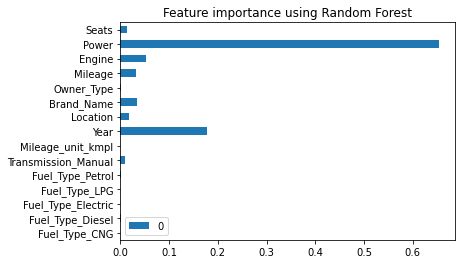

In [13]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

pip_rd=make_pipeline(CT,sc,RandomForestRegressor(random_state=10))

pip_rd.fit(x_train,y_train)

col=list(CT.transformers_[0][1].get_feature_names_out())
col.extend(['Year','Location','Brand_Name','Owner_Type'])
col.extend(list(x.columns[CT.transformers_[5][2]]))
pd.DataFrame(pip_rd['randomforestregressor'].feature_importances_,col).plot.barh()
plt.title("Feature importance using Random Forest")

<b>We observe that Owner_Type, Mileage_unit, Fuel_Type is very less importance show remove these feature and train mode again </b>

In [14]:
df_fs=df.drop(["Owner_Type",'Mileage_unit',"Fuel_Type"],axis=1)


# Create new dependent and independent variable 
x_fs=df_fs.drop('Price',axis=1)
y_fs=df_fs.Price


#Column Transformer

CT_Fs=make_column_transformer((onhot,["Transmission"]),
                              (car_age,["Year"]),
                               (target_en,["Location"]),
                              (Freq_en,["Brand_Name"]),
                              remainder='passthrough')

<b> Train model after feature selection <b/>

In [15]:
for model in models:
    summary=Training(models[model],CT_Fs,x_fs,y_fs)
    Model_Summary=Model_Summary.append({"Model_name":model +"_FS","RSME":summary[0],
                                        "Test r2_score":summary[1],"Train r2_score":summary[2],
                                       "Variance":summary[3]},ignore_index=True)

Learning rate set to 0.051033
0:	learn: 10.8804535	total: 2.92ms	remaining: 2.92s
1:	learn: 10.5036307	total: 5.71ms	remaining: 2.85s
2:	learn: 10.1604682	total: 8.46ms	remaining: 2.81s
3:	learn: 9.8222807	total: 11.2ms	remaining: 2.79s
4:	learn: 9.5022329	total: 13.3ms	remaining: 2.65s
5:	learn: 9.2011153	total: 16.1ms	remaining: 2.67s
6:	learn: 8.9040000	total: 18.9ms	remaining: 2.69s
7:	learn: 8.6212208	total: 21.7ms	remaining: 2.69s
8:	learn: 8.3549222	total: 24.5ms	remaining: 2.69s
9:	learn: 8.1151291	total: 27.2ms	remaining: 2.69s
10:	learn: 7.8915651	total: 29.9ms	remaining: 2.69s
11:	learn: 7.6779487	total: 33.4ms	remaining: 2.75s
12:	learn: 7.4716489	total: 36.3ms	remaining: 2.75s
13:	learn: 7.2755275	total: 39ms	remaining: 2.74s
14:	learn: 7.0942209	total: 41.8ms	remaining: 2.74s
15:	learn: 6.9136057	total: 44.6ms	remaining: 2.74s
16:	learn: 6.7398490	total: 47.4ms	remaining: 2.74s
17:	learn: 6.5833145	total: 50.3ms	remaining: 2.75s
18:	learn: 6.4361454	total: 53.3ms	remainin

179:	learn: 2.9744146	total: 497ms	remaining: 2.26s
180:	learn: 2.9700991	total: 500ms	remaining: 2.26s
181:	learn: 2.9633370	total: 502ms	remaining: 2.26s
182:	learn: 2.9595742	total: 505ms	remaining: 2.25s
183:	learn: 2.9525095	total: 507ms	remaining: 2.25s
184:	learn: 2.9420359	total: 510ms	remaining: 2.25s
185:	learn: 2.9354984	total: 513ms	remaining: 2.24s
186:	learn: 2.9318956	total: 515ms	remaining: 2.24s
187:	learn: 2.9252277	total: 518ms	remaining: 2.24s
188:	learn: 2.9215927	total: 521ms	remaining: 2.23s
189:	learn: 2.9183684	total: 523ms	remaining: 2.23s
190:	learn: 2.9151815	total: 526ms	remaining: 2.23s
191:	learn: 2.9105016	total: 529ms	remaining: 2.22s
192:	learn: 2.9035953	total: 531ms	remaining: 2.22s
193:	learn: 2.8997495	total: 534ms	remaining: 2.22s
194:	learn: 2.8887413	total: 537ms	remaining: 2.22s
195:	learn: 2.8873166	total: 538ms	remaining: 2.21s
196:	learn: 2.8784900	total: 541ms	remaining: 2.21s
197:	learn: 2.8751111	total: 544ms	remaining: 2.2s
198:	learn: 2

364:	learn: 2.2466743	total: 989ms	remaining: 1.72s
365:	learn: 2.2433487	total: 992ms	remaining: 1.72s
366:	learn: 2.2414836	total: 995ms	remaining: 1.72s
367:	learn: 2.2385757	total: 998ms	remaining: 1.71s
368:	learn: 2.2364985	total: 1s	remaining: 1.71s
369:	learn: 2.2343624	total: 1s	remaining: 1.71s
370:	learn: 2.2311755	total: 1.01s	remaining: 1.71s
371:	learn: 2.2303791	total: 1.01s	remaining: 1.7s
372:	learn: 2.2271097	total: 1.01s	remaining: 1.7s
373:	learn: 2.2259769	total: 1.01s	remaining: 1.7s
374:	learn: 2.2222642	total: 1.02s	remaining: 1.7s
375:	learn: 2.2211171	total: 1.02s	remaining: 1.69s
376:	learn: 2.2196015	total: 1.02s	remaining: 1.69s
377:	learn: 2.2185387	total: 1.02s	remaining: 1.69s
378:	learn: 2.2167528	total: 1.03s	remaining: 1.69s
379:	learn: 2.2141770	total: 1.03s	remaining: 1.68s
380:	learn: 2.2115158	total: 1.03s	remaining: 1.68s
381:	learn: 2.2095374	total: 1.04s	remaining: 1.68s
382:	learn: 2.2060181	total: 1.04s	remaining: 1.68s
383:	learn: 2.2021582	

537:	learn: 1.9067506	total: 1.48s	remaining: 1.27s
538:	learn: 1.9059971	total: 1.48s	remaining: 1.27s
539:	learn: 1.9044399	total: 1.49s	remaining: 1.27s
540:	learn: 1.9027503	total: 1.49s	remaining: 1.26s
541:	learn: 1.9010045	total: 1.49s	remaining: 1.26s
542:	learn: 1.8993749	total: 1.5s	remaining: 1.26s
543:	learn: 1.8980970	total: 1.5s	remaining: 1.25s
544:	learn: 1.8962435	total: 1.5s	remaining: 1.25s
545:	learn: 1.8932992	total: 1.5s	remaining: 1.25s
546:	learn: 1.8926738	total: 1.51s	remaining: 1.25s
547:	learn: 1.8912931	total: 1.51s	remaining: 1.24s
548:	learn: 1.8895819	total: 1.51s	remaining: 1.24s
549:	learn: 1.8883149	total: 1.51s	remaining: 1.24s
550:	learn: 1.8866207	total: 1.52s	remaining: 1.24s
551:	learn: 1.8857281	total: 1.52s	remaining: 1.23s
552:	learn: 1.8835745	total: 1.52s	remaining: 1.23s
553:	learn: 1.8825601	total: 1.52s	remaining: 1.23s
554:	learn: 1.8800186	total: 1.53s	remaining: 1.23s
555:	learn: 1.8788767	total: 1.53s	remaining: 1.22s
556:	learn: 1.87

720:	learn: 1.6666046	total: 1.98s	remaining: 767ms
721:	learn: 1.6662094	total: 1.98s	remaining: 764ms
722:	learn: 1.6644839	total: 1.99s	remaining: 761ms
723:	learn: 1.6636506	total: 1.99s	remaining: 759ms
724:	learn: 1.6619450	total: 1.99s	remaining: 756ms
725:	learn: 1.6610019	total: 2s	remaining: 753ms
726:	learn: 1.6606038	total: 2s	remaining: 750ms
727:	learn: 1.6599273	total: 2s	remaining: 747ms
728:	learn: 1.6577139	total: 2s	remaining: 745ms
729:	learn: 1.6570772	total: 2s	remaining: 742ms
730:	learn: 1.6560378	total: 2.01s	remaining: 739ms
731:	learn: 1.6543160	total: 2.01s	remaining: 736ms
732:	learn: 1.6531804	total: 2.01s	remaining: 734ms
733:	learn: 1.6507238	total: 2.02s	remaining: 731ms
734:	learn: 1.6493613	total: 2.02s	remaining: 728ms
735:	learn: 1.6480000	total: 2.02s	remaining: 725ms
736:	learn: 1.6468524	total: 2.02s	remaining: 723ms
737:	learn: 1.6468171	total: 2.03s	remaining: 720ms
738:	learn: 1.6457589	total: 2.03s	remaining: 717ms
739:	learn: 1.6444926	total

903:	learn: 1.4841243	total: 2.48s	remaining: 263ms
904:	learn: 1.4835727	total: 2.48s	remaining: 260ms
905:	learn: 1.4826956	total: 2.48s	remaining: 258ms
906:	learn: 1.4823813	total: 2.49s	remaining: 255ms
907:	learn: 1.4822858	total: 2.49s	remaining: 252ms
908:	learn: 1.4807329	total: 2.49s	remaining: 249ms
909:	learn: 1.4798318	total: 2.49s	remaining: 247ms
910:	learn: 1.4787062	total: 2.5s	remaining: 244ms
911:	learn: 1.4772712	total: 2.5s	remaining: 241ms
912:	learn: 1.4764633	total: 2.5s	remaining: 238ms
913:	learn: 1.4759611	total: 2.5s	remaining: 236ms
914:	learn: 1.4753589	total: 2.51s	remaining: 233ms
915:	learn: 1.4745251	total: 2.51s	remaining: 230ms
916:	learn: 1.4726054	total: 2.51s	remaining: 227ms
917:	learn: 1.4715434	total: 2.52s	remaining: 225ms
918:	learn: 1.4700287	total: 2.52s	remaining: 222ms
919:	learn: 1.4689023	total: 2.52s	remaining: 219ms
920:	learn: 1.4683489	total: 2.52s	remaining: 216ms
921:	learn: 1.4679389	total: 2.53s	remaining: 214ms
922:	learn: 1.46

116:	learn: 3.3449866	total: 321ms	remaining: 2.42s
117:	learn: 3.3378883	total: 323ms	remaining: 2.42s
118:	learn: 3.3241681	total: 326ms	remaining: 2.41s
119:	learn: 3.3180962	total: 329ms	remaining: 2.41s
120:	learn: 3.3107291	total: 331ms	remaining: 2.41s
121:	learn: 3.3044571	total: 334ms	remaining: 2.4s
122:	learn: 3.2997488	total: 337ms	remaining: 2.4s
123:	learn: 3.2950276	total: 339ms	remaining: 2.4s
124:	learn: 3.2895982	total: 342ms	remaining: 2.39s
125:	learn: 3.2768912	total: 345ms	remaining: 2.39s
126:	learn: 3.2720992	total: 347ms	remaining: 2.39s
127:	learn: 3.2656768	total: 350ms	remaining: 2.38s
128:	learn: 3.2564554	total: 353ms	remaining: 2.38s
129:	learn: 3.2547897	total: 355ms	remaining: 2.38s
130:	learn: 3.2434588	total: 358ms	remaining: 2.38s
131:	learn: 3.2378924	total: 361ms	remaining: 2.37s
132:	learn: 3.2290325	total: 364ms	remaining: 2.37s
133:	learn: 3.2168689	total: 366ms	remaining: 2.37s
134:	learn: 3.2116400	total: 369ms	remaining: 2.36s
135:	learn: 3.2

299:	learn: 2.4593282	total: 813ms	remaining: 1.9s
300:	learn: 2.4528607	total: 816ms	remaining: 1.89s
301:	learn: 2.4466801	total: 819ms	remaining: 1.89s
302:	learn: 2.4433741	total: 822ms	remaining: 1.89s
303:	learn: 2.4379249	total: 825ms	remaining: 1.89s
304:	learn: 2.4312699	total: 828ms	remaining: 1.89s
305:	learn: 2.4273478	total: 831ms	remaining: 1.88s
306:	learn: 2.4223439	total: 834ms	remaining: 1.88s
307:	learn: 2.4205055	total: 837ms	remaining: 1.88s
308:	learn: 2.4178086	total: 840ms	remaining: 1.88s
309:	learn: 2.4176705	total: 843ms	remaining: 1.88s
310:	learn: 2.4175364	total: 845ms	remaining: 1.87s
311:	learn: 2.4162269	total: 849ms	remaining: 1.87s
312:	learn: 2.4106460	total: 851ms	remaining: 1.87s
313:	learn: 2.4079914	total: 854ms	remaining: 1.86s
314:	learn: 2.4026118	total: 857ms	remaining: 1.86s
315:	learn: 2.3987732	total: 861ms	remaining: 1.86s
316:	learn: 2.3950537	total: 864ms	remaining: 1.86s
317:	learn: 2.3897678	total: 867ms	remaining: 1.86s
318:	learn: 2

462:	learn: 2.0329443	total: 1.3s	remaining: 1.51s
463:	learn: 2.0320763	total: 1.3s	remaining: 1.5s
464:	learn: 2.0295506	total: 1.3s	remaining: 1.5s
465:	learn: 2.0274143	total: 1.31s	remaining: 1.5s
466:	learn: 2.0264431	total: 1.31s	remaining: 1.5s
467:	learn: 2.0247073	total: 1.31s	remaining: 1.49s
468:	learn: 2.0211416	total: 1.32s	remaining: 1.49s
469:	learn: 2.0193536	total: 1.32s	remaining: 1.49s
470:	learn: 2.0159682	total: 1.32s	remaining: 1.49s
471:	learn: 2.0136960	total: 1.33s	remaining: 1.48s
472:	learn: 2.0118826	total: 1.33s	remaining: 1.48s
473:	learn: 2.0111601	total: 1.33s	remaining: 1.48s
474:	learn: 2.0104282	total: 1.33s	remaining: 1.48s
475:	learn: 2.0101883	total: 1.34s	remaining: 1.47s
476:	learn: 2.0083838	total: 1.34s	remaining: 1.47s
477:	learn: 2.0062753	total: 1.34s	remaining: 1.47s
478:	learn: 2.0040626	total: 1.35s	remaining: 1.47s
479:	learn: 2.0029742	total: 1.35s	remaining: 1.46s
480:	learn: 2.0012307	total: 1.35s	remaining: 1.46s
481:	learn: 1.99807

635:	learn: 1.7631832	total: 1.79s	remaining: 1.02s
636:	learn: 1.7622204	total: 1.79s	remaining: 1.02s
637:	learn: 1.7617483	total: 1.8s	remaining: 1.02s
638:	learn: 1.7607099	total: 1.8s	remaining: 1.02s
639:	learn: 1.7582770	total: 1.8s	remaining: 1.01s
640:	learn: 1.7578183	total: 1.8s	remaining: 1.01s
641:	learn: 1.7568461	total: 1.81s	remaining: 1.01s
642:	learn: 1.7556496	total: 1.81s	remaining: 1s
643:	learn: 1.7549354	total: 1.81s	remaining: 1s
644:	learn: 1.7539600	total: 1.81s	remaining: 999ms
645:	learn: 1.7524619	total: 1.82s	remaining: 996ms
646:	learn: 1.7508426	total: 1.82s	remaining: 994ms
647:	learn: 1.7482721	total: 1.82s	remaining: 991ms
648:	learn: 1.7467742	total: 1.83s	remaining: 988ms
649:	learn: 1.7456083	total: 1.83s	remaining: 985ms
650:	learn: 1.7441830	total: 1.83s	remaining: 982ms
651:	learn: 1.7419867	total: 1.83s	remaining: 980ms
652:	learn: 1.7405577	total: 1.84s	remaining: 977ms
653:	learn: 1.7394949	total: 1.84s	remaining: 974ms
654:	learn: 1.7389416	

816:	learn: 1.5641640	total: 2.29s	remaining: 512ms
817:	learn: 1.5627540	total: 2.29s	remaining: 509ms
818:	learn: 1.5621986	total: 2.29s	remaining: 506ms
819:	learn: 1.5615221	total: 2.29s	remaining: 504ms
820:	learn: 1.5593321	total: 2.3s	remaining: 501ms
821:	learn: 1.5581805	total: 2.3s	remaining: 498ms
822:	learn: 1.5574149	total: 2.3s	remaining: 495ms
823:	learn: 1.5566706	total: 2.31s	remaining: 492ms
824:	learn: 1.5555124	total: 2.31s	remaining: 490ms
825:	learn: 1.5548497	total: 2.31s	remaining: 487ms
826:	learn: 1.5540061	total: 2.31s	remaining: 484ms
827:	learn: 1.5529783	total: 2.32s	remaining: 481ms
828:	learn: 1.5525573	total: 2.32s	remaining: 478ms
829:	learn: 1.5514049	total: 2.32s	remaining: 476ms
830:	learn: 1.5496341	total: 2.32s	remaining: 473ms
831:	learn: 1.5491167	total: 2.33s	remaining: 470ms
832:	learn: 1.5474522	total: 2.33s	remaining: 467ms
833:	learn: 1.5456467	total: 2.33s	remaining: 464ms
834:	learn: 1.5441885	total: 2.33s	remaining: 462ms
835:	learn: 1.5

995:	learn: 1.4065945	total: 2.78s	remaining: 11.2ms
996:	learn: 1.4053657	total: 2.78s	remaining: 8.37ms
997:	learn: 1.4048030	total: 2.79s	remaining: 5.58ms
998:	learn: 1.4038864	total: 2.79s	remaining: 2.79ms
999:	learn: 1.4033185	total: 2.79s	remaining: 0us
Learning rate set to 0.051033
0:	learn: 10.8804535	total: 3.31ms	remaining: 3.3s
1:	learn: 10.5036307	total: 6.36ms	remaining: 3.17s
2:	learn: 10.1604682	total: 9.3ms	remaining: 3.09s
3:	learn: 9.8222807	total: 12.3ms	remaining: 3.05s
4:	learn: 9.5022329	total: 14.6ms	remaining: 2.91s
5:	learn: 9.2011153	total: 17.7ms	remaining: 2.92s
6:	learn: 8.9040000	total: 20.7ms	remaining: 2.94s
7:	learn: 8.6212208	total: 23.7ms	remaining: 2.94s
8:	learn: 8.3549222	total: 26.7ms	remaining: 2.94s
9:	learn: 8.1151291	total: 29.9ms	remaining: 2.96s
10:	learn: 7.8915651	total: 32.8ms	remaining: 2.95s
11:	learn: 7.6779487	total: 35.8ms	remaining: 2.94s
12:	learn: 7.4716489	total: 38.7ms	remaining: 2.94s
13:	learn: 7.2755275	total: 41.8ms	remain

178:	learn: 2.9773036	total: 485ms	remaining: 2.23s
179:	learn: 2.9744146	total: 488ms	remaining: 2.22s
180:	learn: 2.9700991	total: 491ms	remaining: 2.22s
181:	learn: 2.9633370	total: 493ms	remaining: 2.22s
182:	learn: 2.9595742	total: 496ms	remaining: 2.21s
183:	learn: 2.9525095	total: 499ms	remaining: 2.21s
184:	learn: 2.9420359	total: 501ms	remaining: 2.21s
185:	learn: 2.9354984	total: 504ms	remaining: 2.21s
186:	learn: 2.9318956	total: 507ms	remaining: 2.2s
187:	learn: 2.9252277	total: 509ms	remaining: 2.2s
188:	learn: 2.9215927	total: 512ms	remaining: 2.2s
189:	learn: 2.9183684	total: 515ms	remaining: 2.19s
190:	learn: 2.9151815	total: 518ms	remaining: 2.19s
191:	learn: 2.9105016	total: 520ms	remaining: 2.19s
192:	learn: 2.9035953	total: 523ms	remaining: 2.19s
193:	learn: 2.8997495	total: 525ms	remaining: 2.18s
194:	learn: 2.8887413	total: 528ms	remaining: 2.18s
195:	learn: 2.8873166	total: 530ms	remaining: 2.17s
196:	learn: 2.8784900	total: 532ms	remaining: 2.17s
197:	learn: 2.8

357:	learn: 2.2696271	total: 975ms	remaining: 1.75s
358:	learn: 2.2678294	total: 978ms	remaining: 1.75s
359:	learn: 2.2643875	total: 981ms	remaining: 1.74s
360:	learn: 2.2594804	total: 984ms	remaining: 1.74s
361:	learn: 2.2557158	total: 987ms	remaining: 1.74s
362:	learn: 2.2512892	total: 990ms	remaining: 1.74s
363:	learn: 2.2483297	total: 993ms	remaining: 1.74s
364:	learn: 2.2466743	total: 996ms	remaining: 1.73s
365:	learn: 2.2433487	total: 999ms	remaining: 1.73s
366:	learn: 2.2414836	total: 1s	remaining: 1.73s
367:	learn: 2.2385757	total: 1s	remaining: 1.73s
368:	learn: 2.2364985	total: 1.01s	remaining: 1.72s
369:	learn: 2.2343624	total: 1.01s	remaining: 1.72s
370:	learn: 2.2311755	total: 1.01s	remaining: 1.72s
371:	learn: 2.2303791	total: 1.02s	remaining: 1.72s
372:	learn: 2.2271097	total: 1.02s	remaining: 1.71s
373:	learn: 2.2259769	total: 1.02s	remaining: 1.71s
374:	learn: 2.2222642	total: 1.02s	remaining: 1.71s
375:	learn: 2.2211171	total: 1.03s	remaining: 1.71s
376:	learn: 2.2196

537:	learn: 1.9067506	total: 1.62s	remaining: 1.39s
538:	learn: 1.9059971	total: 1.63s	remaining: 1.39s
539:	learn: 1.9044399	total: 1.63s	remaining: 1.39s
540:	learn: 1.9027503	total: 1.63s	remaining: 1.38s
541:	learn: 1.9010045	total: 1.63s	remaining: 1.38s
542:	learn: 1.8993749	total: 1.64s	remaining: 1.38s
543:	learn: 1.8980970	total: 1.64s	remaining: 1.37s
544:	learn: 1.8962435	total: 1.64s	remaining: 1.37s
545:	learn: 1.8932992	total: 1.64s	remaining: 1.37s
546:	learn: 1.8926738	total: 1.65s	remaining: 1.36s
547:	learn: 1.8912931	total: 1.65s	remaining: 1.36s
548:	learn: 1.8895819	total: 1.65s	remaining: 1.36s
549:	learn: 1.8883149	total: 1.66s	remaining: 1.35s
550:	learn: 1.8866207	total: 1.66s	remaining: 1.35s
551:	learn: 1.8857281	total: 1.66s	remaining: 1.35s
552:	learn: 1.8835745	total: 1.66s	remaining: 1.34s
553:	learn: 1.8825601	total: 1.67s	remaining: 1.34s
554:	learn: 1.8800186	total: 1.67s	remaining: 1.34s
555:	learn: 1.8788767	total: 1.67s	remaining: 1.33s
556:	learn: 

745:	learn: 1.6383930	total: 2.28s	remaining: 775ms
746:	learn: 1.6373717	total: 2.28s	remaining: 772ms
747:	learn: 1.6360691	total: 2.28s	remaining: 769ms
748:	learn: 1.6350546	total: 2.29s	remaining: 766ms
749:	learn: 1.6339181	total: 2.29s	remaining: 763ms
750:	learn: 1.6332044	total: 2.29s	remaining: 760ms
751:	learn: 1.6324180	total: 2.29s	remaining: 757ms
752:	learn: 1.6309496	total: 2.3s	remaining: 754ms
753:	learn: 1.6299642	total: 2.3s	remaining: 751ms
754:	learn: 1.6282816	total: 2.3s	remaining: 748ms
755:	learn: 1.6266608	total: 2.31s	remaining: 745ms
756:	learn: 1.6243951	total: 2.31s	remaining: 742ms
757:	learn: 1.6228401	total: 2.31s	remaining: 739ms
758:	learn: 1.6219177	total: 2.32s	remaining: 735ms
759:	learn: 1.6208104	total: 2.32s	remaining: 732ms
760:	learn: 1.6207252	total: 2.32s	remaining: 729ms
761:	learn: 1.6199802	total: 2.32s	remaining: 726ms
762:	learn: 1.6192349	total: 2.33s	remaining: 723ms
763:	learn: 1.6186861	total: 2.33s	remaining: 720ms
764:	learn: 1.6

924:	learn: 1.4658319	total: 2.77s	remaining: 224ms
925:	learn: 1.4651736	total: 2.77s	remaining: 221ms
926:	learn: 1.4643155	total: 2.77s	remaining: 218ms
927:	learn: 1.4625160	total: 2.78s	remaining: 215ms
928:	learn: 1.4621487	total: 2.78s	remaining: 212ms
929:	learn: 1.4612082	total: 2.78s	remaining: 209ms
930:	learn: 1.4606054	total: 2.78s	remaining: 206ms
931:	learn: 1.4601223	total: 2.79s	remaining: 203ms
932:	learn: 1.4595814	total: 2.79s	remaining: 200ms
933:	learn: 1.4590215	total: 2.79s	remaining: 197ms
934:	learn: 1.4582624	total: 2.79s	remaining: 194ms
935:	learn: 1.4580419	total: 2.8s	remaining: 191ms
936:	learn: 1.4566465	total: 2.8s	remaining: 188ms
937:	learn: 1.4556248	total: 2.8s	remaining: 185ms
938:	learn: 1.4549067	total: 2.81s	remaining: 182ms
939:	learn: 1.4543374	total: 2.81s	remaining: 179ms
940:	learn: 1.4535701	total: 2.81s	remaining: 176ms
941:	learn: 1.4525006	total: 2.81s	remaining: 173ms
942:	learn: 1.4521483	total: 2.82s	remaining: 170ms
943:	learn: 1.4

127:	learn: 3.3590833	total: 318ms	remaining: 2.16s
128:	learn: 3.3479611	total: 320ms	remaining: 2.16s
129:	learn: 3.3464199	total: 323ms	remaining: 2.16s
130:	learn: 3.3379846	total: 326ms	remaining: 2.16s
131:	learn: 3.3273517	total: 329ms	remaining: 2.16s
132:	learn: 3.3223348	total: 331ms	remaining: 2.16s
133:	learn: 3.3130911	total: 334ms	remaining: 2.16s
134:	learn: 3.3021210	total: 337ms	remaining: 2.16s
135:	learn: 3.3006546	total: 339ms	remaining: 2.15s
136:	learn: 3.2905156	total: 342ms	remaining: 2.15s
137:	learn: 3.2829514	total: 344ms	remaining: 2.15s
138:	learn: 3.2712976	total: 347ms	remaining: 2.15s
139:	learn: 3.2655251	total: 350ms	remaining: 2.15s
140:	learn: 3.2553573	total: 353ms	remaining: 2.15s
141:	learn: 3.2450861	total: 355ms	remaining: 2.15s
142:	learn: 3.2414176	total: 358ms	remaining: 2.14s
143:	learn: 3.2365702	total: 360ms	remaining: 2.14s
144:	learn: 3.2361558	total: 362ms	remaining: 2.13s
145:	learn: 3.2291821	total: 364ms	remaining: 2.13s
146:	learn: 

318:	learn: 2.3812270	total: 806ms	remaining: 1.72s
319:	learn: 2.3747471	total: 809ms	remaining: 1.72s
320:	learn: 2.3743401	total: 811ms	remaining: 1.72s
321:	learn: 2.3725371	total: 814ms	remaining: 1.71s
322:	learn: 2.3693959	total: 816ms	remaining: 1.71s
323:	learn: 2.3639710	total: 819ms	remaining: 1.71s
324:	learn: 2.3611737	total: 821ms	remaining: 1.71s
325:	learn: 2.3559337	total: 824ms	remaining: 1.7s
326:	learn: 2.3520699	total: 827ms	remaining: 1.7s
327:	learn: 2.3508339	total: 829ms	remaining: 1.7s
328:	learn: 2.3477248	total: 832ms	remaining: 1.7s
329:	learn: 2.3442810	total: 834ms	remaining: 1.69s
330:	learn: 2.3402742	total: 837ms	remaining: 1.69s
331:	learn: 2.3380091	total: 839ms	remaining: 1.69s
332:	learn: 2.3360566	total: 842ms	remaining: 1.69s
333:	learn: 2.3312686	total: 845ms	remaining: 1.68s
334:	learn: 2.3281178	total: 847ms	remaining: 1.68s
335:	learn: 2.3251054	total: 850ms	remaining: 1.68s
336:	learn: 2.3237169	total: 852ms	remaining: 1.68s
337:	learn: 2.32

512:	learn: 1.9279480	total: 1.3s	remaining: 1.23s
513:	learn: 1.9250560	total: 1.3s	remaining: 1.23s
514:	learn: 1.9227186	total: 1.3s	remaining: 1.23s
515:	learn: 1.9215522	total: 1.31s	remaining: 1.23s
516:	learn: 1.9203753	total: 1.31s	remaining: 1.22s
517:	learn: 1.9183907	total: 1.31s	remaining: 1.22s
518:	learn: 1.9161766	total: 1.31s	remaining: 1.22s
519:	learn: 1.9136547	total: 1.32s	remaining: 1.22s
520:	learn: 1.9110703	total: 1.32s	remaining: 1.21s
521:	learn: 1.9100105	total: 1.32s	remaining: 1.21s
522:	learn: 1.9080556	total: 1.32s	remaining: 1.21s
523:	learn: 1.9055837	total: 1.33s	remaining: 1.21s
524:	learn: 1.9044051	total: 1.33s	remaining: 1.2s
525:	learn: 1.9033262	total: 1.33s	remaining: 1.2s
526:	learn: 1.9009414	total: 1.33s	remaining: 1.2s
527:	learn: 1.8997772	total: 1.34s	remaining: 1.2s
528:	learn: 1.8973829	total: 1.34s	remaining: 1.19s
529:	learn: 1.8961253	total: 1.34s	remaining: 1.19s
530:	learn: 1.8947722	total: 1.35s	remaining: 1.19s
531:	learn: 1.89085

702:	learn: 1.6544388	total: 1.79s	remaining: 755ms
703:	learn: 1.6528950	total: 1.79s	remaining: 753ms
704:	learn: 1.6512170	total: 1.79s	remaining: 750ms
705:	learn: 1.6511323	total: 1.79s	remaining: 747ms
706:	learn: 1.6507973	total: 1.8s	remaining: 745ms
707:	learn: 1.6500869	total: 1.8s	remaining: 742ms
708:	learn: 1.6494614	total: 1.8s	remaining: 740ms
709:	learn: 1.6489925	total: 1.8s	remaining: 737ms
710:	learn: 1.6474683	total: 1.81s	remaining: 734ms
711:	learn: 1.6469029	total: 1.81s	remaining: 732ms
712:	learn: 1.6455850	total: 1.81s	remaining: 729ms
713:	learn: 1.6445144	total: 1.81s	remaining: 727ms
714:	learn: 1.6433454	total: 1.82s	remaining: 724ms
715:	learn: 1.6419385	total: 1.82s	remaining: 722ms
716:	learn: 1.6412698	total: 1.82s	remaining: 719ms
717:	learn: 1.6404961	total: 1.82s	remaining: 717ms
718:	learn: 1.6397116	total: 1.83s	remaining: 714ms
719:	learn: 1.6380893	total: 1.83s	remaining: 712ms
720:	learn: 1.6371710	total: 1.83s	remaining: 709ms
721:	learn: 1.63

895:	learn: 1.4671653	total: 2.28s	remaining: 265ms
896:	learn: 1.4665351	total: 2.28s	remaining: 262ms
897:	learn: 1.4652969	total: 2.29s	remaining: 260ms
898:	learn: 1.4645260	total: 2.29s	remaining: 257ms
899:	learn: 1.4626623	total: 2.29s	remaining: 255ms
900:	learn: 1.4620426	total: 2.29s	remaining: 252ms
901:	learn: 1.4606465	total: 2.3s	remaining: 249ms
902:	learn: 1.4602293	total: 2.3s	remaining: 247ms
903:	learn: 1.4592933	total: 2.3s	remaining: 244ms
904:	learn: 1.4588924	total: 2.3s	remaining: 242ms
905:	learn: 1.4582527	total: 2.31s	remaining: 239ms
906:	learn: 1.4572643	total: 2.31s	remaining: 237ms
907:	learn: 1.4570527	total: 2.31s	remaining: 234ms
908:	learn: 1.4555187	total: 2.31s	remaining: 232ms
909:	learn: 1.4550197	total: 2.32s	remaining: 229ms
910:	learn: 1.4543504	total: 2.32s	remaining: 227ms
911:	learn: 1.4530302	total: 2.32s	remaining: 224ms
912:	learn: 1.4515708	total: 2.33s	remaining: 222ms
913:	learn: 1.4508335	total: 2.33s	remaining: 219ms
914:	learn: 1.44

64:	learn: 3.6737941	total: 181ms	remaining: 2.6s
65:	learn: 3.6493850	total: 184ms	remaining: 2.6s
66:	learn: 3.6292925	total: 187ms	remaining: 2.6s
67:	learn: 3.6075895	total: 189ms	remaining: 2.59s
68:	learn: 3.5873945	total: 192ms	remaining: 2.6s
69:	learn: 3.5654675	total: 196ms	remaining: 2.6s
70:	learn: 3.5486965	total: 199ms	remaining: 2.6s
71:	learn: 3.5313353	total: 201ms	remaining: 2.59s
72:	learn: 3.5151138	total: 204ms	remaining: 2.59s
73:	learn: 3.4980008	total: 207ms	remaining: 2.59s
74:	learn: 3.4824125	total: 211ms	remaining: 2.6s
75:	learn: 3.4654225	total: 214ms	remaining: 2.6s
76:	learn: 3.4542794	total: 216ms	remaining: 2.59s
77:	learn: 3.4343600	total: 219ms	remaining: 2.59s
78:	learn: 3.4215646	total: 222ms	remaining: 2.58s
79:	learn: 3.4067461	total: 224ms	remaining: 2.58s
80:	learn: 3.3958869	total: 227ms	remaining: 2.57s
81:	learn: 3.3857625	total: 230ms	remaining: 2.58s
82:	learn: 3.3750163	total: 233ms	remaining: 2.57s
83:	learn: 3.3618321	total: 236ms	remai

252:	learn: 2.3259906	total: 668ms	remaining: 1.97s
253:	learn: 2.3246921	total: 671ms	remaining: 1.97s
254:	learn: 2.3226766	total: 673ms	remaining: 1.97s
255:	learn: 2.3159870	total: 676ms	remaining: 1.96s
256:	learn: 2.3113862	total: 678ms	remaining: 1.96s
257:	learn: 2.3080595	total: 681ms	remaining: 1.96s
258:	learn: 2.3061326	total: 684ms	remaining: 1.96s
259:	learn: 2.3018073	total: 686ms	remaining: 1.95s
260:	learn: 2.2994484	total: 689ms	remaining: 1.95s
261:	learn: 2.2953873	total: 691ms	remaining: 1.95s
262:	learn: 2.2880260	total: 694ms	remaining: 1.94s
263:	learn: 2.2848796	total: 696ms	remaining: 1.94s
264:	learn: 2.2826724	total: 699ms	remaining: 1.94s
265:	learn: 2.2784936	total: 702ms	remaining: 1.94s
266:	learn: 2.2755502	total: 704ms	remaining: 1.93s
267:	learn: 2.2684849	total: 707ms	remaining: 1.93s
268:	learn: 2.2637341	total: 709ms	remaining: 1.93s
269:	learn: 2.2609115	total: 712ms	remaining: 1.92s
270:	learn: 2.2569332	total: 714ms	remaining: 1.92s
271:	learn: 

428:	learn: 1.8406022	total: 1.15s	remaining: 1.53s
429:	learn: 1.8390149	total: 1.15s	remaining: 1.53s
430:	learn: 1.8373264	total: 1.16s	remaining: 1.53s
431:	learn: 1.8354183	total: 1.16s	remaining: 1.53s
432:	learn: 1.8328278	total: 1.16s	remaining: 1.52s
433:	learn: 1.8309492	total: 1.17s	remaining: 1.52s
434:	learn: 1.8300162	total: 1.17s	remaining: 1.52s
435:	learn: 1.8262516	total: 1.17s	remaining: 1.51s
436:	learn: 1.8241371	total: 1.17s	remaining: 1.51s
437:	learn: 1.8208515	total: 1.18s	remaining: 1.51s
438:	learn: 1.8180958	total: 1.18s	remaining: 1.51s
439:	learn: 1.8163844	total: 1.18s	remaining: 1.5s
440:	learn: 1.8146614	total: 1.19s	remaining: 1.5s
441:	learn: 1.8133461	total: 1.19s	remaining: 1.5s
442:	learn: 1.8115764	total: 1.19s	remaining: 1.5s
443:	learn: 1.8086228	total: 1.19s	remaining: 1.49s
444:	learn: 1.8069966	total: 1.2s	remaining: 1.49s
445:	learn: 1.8052663	total: 1.2s	remaining: 1.49s
446:	learn: 1.8039443	total: 1.2s	remaining: 1.49s
447:	learn: 1.80235

608:	learn: 1.5657620	total: 1.64s	remaining: 1.05s
609:	learn: 1.5643919	total: 1.64s	remaining: 1.05s
610:	learn: 1.5633747	total: 1.64s	remaining: 1.05s
611:	learn: 1.5625381	total: 1.65s	remaining: 1.04s
612:	learn: 1.5616205	total: 1.65s	remaining: 1.04s
613:	learn: 1.5602003	total: 1.65s	remaining: 1.04s
614:	learn: 1.5585880	total: 1.65s	remaining: 1.03s
615:	learn: 1.5577385	total: 1.66s	remaining: 1.03s
616:	learn: 1.5568043	total: 1.66s	remaining: 1.03s
617:	learn: 1.5557670	total: 1.66s	remaining: 1.03s
618:	learn: 1.5542903	total: 1.66s	remaining: 1.02s
619:	learn: 1.5533028	total: 1.67s	remaining: 1.02s
620:	learn: 1.5524921	total: 1.67s	remaining: 1.02s
621:	learn: 1.5514329	total: 1.67s	remaining: 1.01s
622:	learn: 1.5497727	total: 1.67s	remaining: 1.01s
623:	learn: 1.5491640	total: 1.68s	remaining: 1.01s
624:	learn: 1.5486017	total: 1.68s	remaining: 1.01s
625:	learn: 1.5476797	total: 1.68s	remaining: 1s
626:	learn: 1.5471459	total: 1.68s	remaining: 1s
627:	learn: 1.5457

782:	learn: 1.3842406	total: 2.12s	remaining: 588ms
783:	learn: 1.3832865	total: 2.12s	remaining: 585ms
784:	learn: 1.3826382	total: 2.13s	remaining: 582ms
785:	learn: 1.3821016	total: 2.13s	remaining: 579ms
786:	learn: 1.3815739	total: 2.13s	remaining: 577ms
787:	learn: 1.3804760	total: 2.13s	remaining: 574ms
788:	learn: 1.3792284	total: 2.13s	remaining: 571ms
789:	learn: 1.3775053	total: 2.14s	remaining: 568ms
790:	learn: 1.3768376	total: 2.14s	remaining: 566ms
791:	learn: 1.3761972	total: 2.14s	remaining: 563ms
792:	learn: 1.3758800	total: 2.15s	remaining: 560ms
793:	learn: 1.3746381	total: 2.15s	remaining: 557ms
794:	learn: 1.3739898	total: 2.15s	remaining: 555ms
795:	learn: 1.3736745	total: 2.15s	remaining: 552ms
796:	learn: 1.3722526	total: 2.16s	remaining: 549ms
797:	learn: 1.3713204	total: 2.16s	remaining: 547ms
798:	learn: 1.3704927	total: 2.16s	remaining: 544ms
799:	learn: 1.3695356	total: 2.16s	remaining: 541ms
800:	learn: 1.3689623	total: 2.17s	remaining: 538ms
801:	learn: 

970:	learn: 1.2495777	total: 2.61s	remaining: 77.9ms
971:	learn: 1.2480105	total: 2.61s	remaining: 75.2ms
972:	learn: 1.2477400	total: 2.61s	remaining: 72.5ms
973:	learn: 1.2474841	total: 2.62s	remaining: 69.8ms
974:	learn: 1.2470599	total: 2.62s	remaining: 67.2ms
975:	learn: 1.2462098	total: 2.62s	remaining: 64.5ms
976:	learn: 1.2458533	total: 2.62s	remaining: 61.8ms
977:	learn: 1.2455579	total: 2.63s	remaining: 59.1ms
978:	learn: 1.2451222	total: 2.63s	remaining: 56.4ms
979:	learn: 1.2446367	total: 2.63s	remaining: 53.7ms
980:	learn: 1.2441552	total: 2.63s	remaining: 51ms
981:	learn: 1.2436665	total: 2.64s	remaining: 48.4ms
982:	learn: 1.2431125	total: 2.64s	remaining: 45.7ms
983:	learn: 1.2427225	total: 2.64s	remaining: 43ms
984:	learn: 1.2419420	total: 2.65s	remaining: 40.3ms
985:	learn: 1.2416066	total: 2.65s	remaining: 37.6ms
986:	learn: 1.2410537	total: 2.65s	remaining: 34.9ms
987:	learn: 1.2407598	total: 2.65s	remaining: 32.2ms
988:	learn: 1.2398540	total: 2.66s	remaining: 29.5

184:	learn: 3.0441674	total: 510ms	remaining: 2.25s
185:	learn: 3.0384392	total: 513ms	remaining: 2.24s
186:	learn: 3.0335820	total: 515ms	remaining: 2.24s
187:	learn: 3.0295930	total: 518ms	remaining: 2.24s
188:	learn: 3.0258349	total: 520ms	remaining: 2.23s
189:	learn: 3.0245634	total: 523ms	remaining: 2.23s
190:	learn: 3.0145085	total: 525ms	remaining: 2.22s
191:	learn: 3.0053888	total: 528ms	remaining: 2.22s
192:	learn: 3.0010543	total: 530ms	remaining: 2.22s
193:	learn: 2.9949043	total: 533ms	remaining: 2.21s
194:	learn: 2.9908025	total: 535ms	remaining: 2.21s
195:	learn: 2.9873145	total: 538ms	remaining: 2.21s
196:	learn: 2.9846582	total: 540ms	remaining: 2.2s
197:	learn: 2.9817798	total: 543ms	remaining: 2.2s
198:	learn: 2.9814795	total: 544ms	remaining: 2.19s
199:	learn: 2.9780157	total: 546ms	remaining: 2.19s
200:	learn: 2.9683381	total: 549ms	remaining: 2.18s
201:	learn: 2.9583989	total: 552ms	remaining: 2.18s
202:	learn: 2.9512012	total: 554ms	remaining: 2.18s
203:	learn: 2.

381:	learn: 2.2532371	total: 1s	remaining: 1.62s
382:	learn: 2.2517237	total: 1s	remaining: 1.62s
383:	learn: 2.2511745	total: 1s	remaining: 1.61s
384:	learn: 2.2476251	total: 1.01s	remaining: 1.61s
385:	learn: 2.2461777	total: 1.01s	remaining: 1.61s
386:	learn: 2.2439595	total: 1.01s	remaining: 1.6s
387:	learn: 2.2408875	total: 1.01s	remaining: 1.6s
388:	learn: 2.2379519	total: 1.02s	remaining: 1.6s
389:	learn: 2.2348399	total: 1.02s	remaining: 1.6s
390:	learn: 2.2321099	total: 1.02s	remaining: 1.59s
391:	learn: 2.2293185	total: 1.02s	remaining: 1.59s
392:	learn: 2.2263965	total: 1.03s	remaining: 1.59s
393:	learn: 2.2239694	total: 1.03s	remaining: 1.58s
394:	learn: 2.2210629	total: 1.03s	remaining: 1.58s
395:	learn: 2.2198435	total: 1.03s	remaining: 1.58s
396:	learn: 2.2182428	total: 1.04s	remaining: 1.58s
397:	learn: 2.2148846	total: 1.04s	remaining: 1.57s
398:	learn: 2.2115193	total: 1.04s	remaining: 1.57s
399:	learn: 2.2090036	total: 1.05s	remaining: 1.57s
400:	learn: 2.2057913	tot

590:	learn: 1.8415902	total: 1.65s	remaining: 1.14s
591:	learn: 1.8387466	total: 1.65s	remaining: 1.14s
592:	learn: 1.8382639	total: 1.66s	remaining: 1.14s
593:	learn: 1.8376823	total: 1.66s	remaining: 1.13s
594:	learn: 1.8363551	total: 1.66s	remaining: 1.13s
595:	learn: 1.8354777	total: 1.66s	remaining: 1.13s
596:	learn: 1.8329260	total: 1.67s	remaining: 1.13s
597:	learn: 1.8303470	total: 1.67s	remaining: 1.12s
598:	learn: 1.8288317	total: 1.67s	remaining: 1.12s
599:	learn: 1.8266783	total: 1.67s	remaining: 1.12s
600:	learn: 1.8250805	total: 1.68s	remaining: 1.11s
601:	learn: 1.8235247	total: 1.68s	remaining: 1.11s
602:	learn: 1.8209963	total: 1.68s	remaining: 1.11s
603:	learn: 1.8191170	total: 1.68s	remaining: 1.1s
604:	learn: 1.8177768	total: 1.69s	remaining: 1.1s
605:	learn: 1.8158343	total: 1.69s	remaining: 1.1s
606:	learn: 1.8139360	total: 1.69s	remaining: 1.1s
607:	learn: 1.8126763	total: 1.7s	remaining: 1.09s
608:	learn: 1.8108459	total: 1.7s	remaining: 1.09s
609:	learn: 1.8101

782:	learn: 1.5829036	total: 2.14s	remaining: 593ms
783:	learn: 1.5820485	total: 2.14s	remaining: 591ms
784:	learn: 1.5804797	total: 2.15s	remaining: 588ms
785:	learn: 1.5802054	total: 2.15s	remaining: 585ms
786:	learn: 1.5794309	total: 2.15s	remaining: 582ms
787:	learn: 1.5789445	total: 2.15s	remaining: 579ms
788:	learn: 1.5787387	total: 2.16s	remaining: 577ms
789:	learn: 1.5772528	total: 2.16s	remaining: 574ms
790:	learn: 1.5765290	total: 2.16s	remaining: 571ms
791:	learn: 1.5752513	total: 2.16s	remaining: 568ms
792:	learn: 1.5739736	total: 2.17s	remaining: 566ms
793:	learn: 1.5730573	total: 2.17s	remaining: 563ms
794:	learn: 1.5718509	total: 2.17s	remaining: 560ms
795:	learn: 1.5711886	total: 2.17s	remaining: 557ms
796:	learn: 1.5702078	total: 2.18s	remaining: 554ms
797:	learn: 1.5682559	total: 2.18s	remaining: 552ms
798:	learn: 1.5672844	total: 2.18s	remaining: 549ms
799:	learn: 1.5661442	total: 2.18s	remaining: 546ms
800:	learn: 1.5650923	total: 2.19s	remaining: 543ms
801:	learn: 

964:	learn: 1.4205322	total: 2.63s	remaining: 95.3ms
965:	learn: 1.4197222	total: 2.63s	remaining: 92.5ms
966:	learn: 1.4182710	total: 2.63s	remaining: 89.8ms
967:	learn: 1.4164488	total: 2.63s	remaining: 87.1ms
968:	learn: 1.4155672	total: 2.64s	remaining: 84.4ms
969:	learn: 1.4148643	total: 2.64s	remaining: 81.7ms
970:	learn: 1.4138589	total: 2.64s	remaining: 78.9ms
971:	learn: 1.4131642	total: 2.65s	remaining: 76.2ms
972:	learn: 1.4127908	total: 2.65s	remaining: 73.5ms
973:	learn: 1.4121763	total: 2.65s	remaining: 70.8ms
974:	learn: 1.4118539	total: 2.65s	remaining: 68.1ms
975:	learn: 1.4112282	total: 2.66s	remaining: 65.3ms
976:	learn: 1.4107398	total: 2.66s	remaining: 62.6ms
977:	learn: 1.4097799	total: 2.66s	remaining: 59.9ms
978:	learn: 1.4091369	total: 2.67s	remaining: 57.2ms
979:	learn: 1.4088508	total: 2.67s	remaining: 54.5ms
980:	learn: 1.4084930	total: 2.67s	remaining: 51.8ms
981:	learn: 1.4071909	total: 2.67s	remaining: 49ms
982:	learn: 1.4063582	total: 2.68s	remaining: 46

137:	learn: 3.3401836	total: 339ms	remaining: 2.12s
138:	learn: 3.3341210	total: 342ms	remaining: 2.12s
139:	learn: 3.3263421	total: 344ms	remaining: 2.12s
140:	learn: 3.3185396	total: 347ms	remaining: 2.11s
141:	learn: 3.3129242	total: 350ms	remaining: 2.11s
142:	learn: 3.3075938	total: 352ms	remaining: 2.11s
143:	learn: 3.2982607	total: 355ms	remaining: 2.11s
144:	learn: 3.2915667	total: 357ms	remaining: 2.11s
145:	learn: 3.2837507	total: 360ms	remaining: 2.1s
146:	learn: 3.2760629	total: 362ms	remaining: 2.1s
147:	learn: 3.2700764	total: 365ms	remaining: 2.1s
148:	learn: 3.2615048	total: 368ms	remaining: 2.1s
149:	learn: 3.2557200	total: 370ms	remaining: 2.1s
150:	learn: 3.2498718	total: 373ms	remaining: 2.1s
151:	learn: 3.2430903	total: 375ms	remaining: 2.09s
152:	learn: 3.2379745	total: 378ms	remaining: 2.09s
153:	learn: 3.2325655	total: 380ms	remaining: 2.09s
154:	learn: 3.2282647	total: 383ms	remaining: 2.09s
155:	learn: 3.2195106	total: 386ms	remaining: 2.09s
156:	learn: 3.2106

336:	learn: 2.3867024	total: 829ms	remaining: 1.63s
337:	learn: 2.3863446	total: 831ms	remaining: 1.63s
338:	learn: 2.3836395	total: 833ms	remaining: 1.63s
339:	learn: 2.3781192	total: 836ms	remaining: 1.62s
340:	learn: 2.3733947	total: 839ms	remaining: 1.62s
341:	learn: 2.3722918	total: 841ms	remaining: 1.62s
342:	learn: 2.3682156	total: 843ms	remaining: 1.61s
343:	learn: 2.3640956	total: 846ms	remaining: 1.61s
344:	learn: 2.3635777	total: 849ms	remaining: 1.61s
345:	learn: 2.3634451	total: 851ms	remaining: 1.61s
346:	learn: 2.3601960	total: 854ms	remaining: 1.61s
347:	learn: 2.3583841	total: 857ms	remaining: 1.6s
348:	learn: 2.3534257	total: 860ms	remaining: 1.6s
349:	learn: 2.3483309	total: 862ms	remaining: 1.6s
350:	learn: 2.3460350	total: 865ms	remaining: 1.6s
351:	learn: 2.3418922	total: 868ms	remaining: 1.6s
352:	learn: 2.3372006	total: 871ms	remaining: 1.59s
353:	learn: 2.3324724	total: 873ms	remaining: 1.59s
354:	learn: 2.3323239	total: 876ms	remaining: 1.59s
355:	learn: 2.328

530:	learn: 1.9234964	total: 1.32s	remaining: 1.16s
531:	learn: 1.9223277	total: 1.32s	remaining: 1.16s
532:	learn: 1.9208348	total: 1.32s	remaining: 1.16s
533:	learn: 1.9200565	total: 1.32s	remaining: 1.16s
534:	learn: 1.9192266	total: 1.33s	remaining: 1.15s
535:	learn: 1.9154465	total: 1.33s	remaining: 1.15s
536:	learn: 1.9136186	total: 1.33s	remaining: 1.15s
537:	learn: 1.9119607	total: 1.33s	remaining: 1.15s
538:	learn: 1.9114418	total: 1.34s	remaining: 1.14s
539:	learn: 1.9107384	total: 1.34s	remaining: 1.14s
540:	learn: 1.9088574	total: 1.34s	remaining: 1.14s
541:	learn: 1.9060835	total: 1.34s	remaining: 1.14s
542:	learn: 1.9052724	total: 1.35s	remaining: 1.13s
543:	learn: 1.9039418	total: 1.35s	remaining: 1.13s
544:	learn: 1.9020698	total: 1.35s	remaining: 1.13s
545:	learn: 1.8993612	total: 1.35s	remaining: 1.13s
546:	learn: 1.8975627	total: 1.36s	remaining: 1.12s
547:	learn: 1.8957743	total: 1.36s	remaining: 1.12s
548:	learn: 1.8939609	total: 1.36s	remaining: 1.12s
549:	learn: 

724:	learn: 1.6299012	total: 1.81s	remaining: 687ms
725:	learn: 1.6286863	total: 1.81s	remaining: 684ms
726:	learn: 1.6261891	total: 1.81s	remaining: 682ms
727:	learn: 1.6253478	total: 1.82s	remaining: 679ms
728:	learn: 1.6235060	total: 1.82s	remaining: 677ms
729:	learn: 1.6229319	total: 1.82s	remaining: 674ms
730:	learn: 1.6222771	total: 1.82s	remaining: 672ms
731:	learn: 1.6212981	total: 1.83s	remaining: 669ms
732:	learn: 1.6200052	total: 1.83s	remaining: 667ms
733:	learn: 1.6182127	total: 1.83s	remaining: 665ms
734:	learn: 1.6170119	total: 1.84s	remaining: 662ms
735:	learn: 1.6144370	total: 1.84s	remaining: 660ms
736:	learn: 1.6133162	total: 1.84s	remaining: 657ms
737:	learn: 1.6120680	total: 1.84s	remaining: 655ms
738:	learn: 1.6109869	total: 1.85s	remaining: 652ms
739:	learn: 1.6100441	total: 1.85s	remaining: 650ms
740:	learn: 1.6087926	total: 1.85s	remaining: 647ms
741:	learn: 1.6062501	total: 1.85s	remaining: 645ms
742:	learn: 1.6048675	total: 1.86s	remaining: 642ms
743:	learn: 

919:	learn: 1.4278736	total: 2.31s	remaining: 200ms
920:	learn: 1.4265048	total: 2.31s	remaining: 198ms
921:	learn: 1.4256917	total: 2.31s	remaining: 195ms
922:	learn: 1.4244451	total: 2.31s	remaining: 193ms
923:	learn: 1.4224783	total: 2.31s	remaining: 190ms
924:	learn: 1.4219068	total: 2.32s	remaining: 188ms
925:	learn: 1.4205391	total: 2.32s	remaining: 185ms
926:	learn: 1.4201513	total: 2.32s	remaining: 183ms
927:	learn: 1.4196386	total: 2.33s	remaining: 180ms
928:	learn: 1.4181791	total: 2.33s	remaining: 178ms
929:	learn: 1.4168568	total: 2.33s	remaining: 175ms
930:	learn: 1.4158219	total: 2.33s	remaining: 173ms
931:	learn: 1.4156192	total: 2.33s	remaining: 170ms
932:	learn: 1.4152149	total: 2.34s	remaining: 168ms
933:	learn: 1.4148607	total: 2.34s	remaining: 165ms
934:	learn: 1.4132475	total: 2.34s	remaining: 163ms
935:	learn: 1.4129611	total: 2.35s	remaining: 160ms
936:	learn: 1.4113915	total: 2.35s	remaining: 158ms
937:	learn: 1.4111690	total: 2.35s	remaining: 155ms
938:	learn: 

95:	learn: 3.1963732	total: 248ms	remaining: 2.34s
96:	learn: 3.1851073	total: 251ms	remaining: 2.34s
97:	learn: 3.1722385	total: 254ms	remaining: 2.34s
98:	learn: 3.1589209	total: 257ms	remaining: 2.33s
99:	learn: 3.1521614	total: 259ms	remaining: 2.33s
100:	learn: 3.1446301	total: 262ms	remaining: 2.33s
101:	learn: 3.1380281	total: 265ms	remaining: 2.33s
102:	learn: 3.1306010	total: 267ms	remaining: 2.33s
103:	learn: 3.1183804	total: 270ms	remaining: 2.33s
104:	learn: 3.1108060	total: 273ms	remaining: 2.32s
105:	learn: 3.1057317	total: 275ms	remaining: 2.32s
106:	learn: 3.1011097	total: 278ms	remaining: 2.32s
107:	learn: 3.0898868	total: 280ms	remaining: 2.32s
108:	learn: 3.0824859	total: 283ms	remaining: 2.31s
109:	learn: 3.0809888	total: 286ms	remaining: 2.31s
110:	learn: 3.0747264	total: 288ms	remaining: 2.31s
111:	learn: 3.0599257	total: 291ms	remaining: 2.31s
112:	learn: 3.0587548	total: 293ms	remaining: 2.3s
113:	learn: 3.0488950	total: 296ms	remaining: 2.3s
114:	learn: 3.04387

290:	learn: 2.2377226	total: 735ms	remaining: 1.79s
291:	learn: 2.2306515	total: 738ms	remaining: 1.79s
292:	learn: 2.2245864	total: 740ms	remaining: 1.79s
293:	learn: 2.2241780	total: 742ms	remaining: 1.78s
294:	learn: 2.2213945	total: 745ms	remaining: 1.78s
295:	learn: 2.2179614	total: 748ms	remaining: 1.78s
296:	learn: 2.2146041	total: 750ms	remaining: 1.77s
297:	learn: 2.2104846	total: 753ms	remaining: 1.77s
298:	learn: 2.2086904	total: 755ms	remaining: 1.77s
299:	learn: 2.2069619	total: 757ms	remaining: 1.77s
300:	learn: 2.2039403	total: 760ms	remaining: 1.76s
301:	learn: 2.2023732	total: 762ms	remaining: 1.76s
302:	learn: 2.2009090	total: 765ms	remaining: 1.76s
303:	learn: 2.1994391	total: 767ms	remaining: 1.76s
304:	learn: 2.1950621	total: 770ms	remaining: 1.75s
305:	learn: 2.1919847	total: 773ms	remaining: 1.75s
306:	learn: 2.1894737	total: 775ms	remaining: 1.75s
307:	learn: 2.1856937	total: 778ms	remaining: 1.75s
308:	learn: 2.1809706	total: 780ms	remaining: 1.74s
309:	learn: 

474:	learn: 1.7818001	total: 1.22s	remaining: 1.35s
475:	learn: 1.7802198	total: 1.22s	remaining: 1.34s
476:	learn: 1.7792432	total: 1.23s	remaining: 1.34s
477:	learn: 1.7775110	total: 1.23s	remaining: 1.34s
478:	learn: 1.7765829	total: 1.23s	remaining: 1.34s
479:	learn: 1.7758923	total: 1.23s	remaining: 1.34s
480:	learn: 1.7737006	total: 1.24s	remaining: 1.33s
481:	learn: 1.7710966	total: 1.24s	remaining: 1.33s
482:	learn: 1.7682894	total: 1.24s	remaining: 1.33s
483:	learn: 1.7667997	total: 1.24s	remaining: 1.33s
484:	learn: 1.7652799	total: 1.25s	remaining: 1.32s
485:	learn: 1.7628243	total: 1.25s	remaining: 1.32s
486:	learn: 1.7613759	total: 1.25s	remaining: 1.32s
487:	learn: 1.7608699	total: 1.25s	remaining: 1.32s
488:	learn: 1.7591829	total: 1.26s	remaining: 1.31s
489:	learn: 1.7581880	total: 1.26s	remaining: 1.31s
490:	learn: 1.7550511	total: 1.26s	remaining: 1.31s
491:	learn: 1.7534710	total: 1.27s	remaining: 1.31s
492:	learn: 1.7513476	total: 1.27s	remaining: 1.3s
493:	learn: 1

654:	learn: 1.5364857	total: 1.7s	remaining: 897ms
655:	learn: 1.5348644	total: 1.71s	remaining: 895ms
656:	learn: 1.5341553	total: 1.71s	remaining: 893ms
657:	learn: 1.5327201	total: 1.71s	remaining: 890ms
658:	learn: 1.5321778	total: 1.72s	remaining: 887ms
659:	learn: 1.5297980	total: 1.72s	remaining: 885ms
660:	learn: 1.5286111	total: 1.72s	remaining: 882ms
661:	learn: 1.5273377	total: 1.72s	remaining: 880ms
662:	learn: 1.5258090	total: 1.73s	remaining: 877ms
663:	learn: 1.5246924	total: 1.73s	remaining: 875ms
664:	learn: 1.5233199	total: 1.73s	remaining: 873ms
665:	learn: 1.5225464	total: 1.74s	remaining: 870ms
666:	learn: 1.5211054	total: 1.74s	remaining: 868ms
667:	learn: 1.5205598	total: 1.74s	remaining: 865ms
668:	learn: 1.5188806	total: 1.74s	remaining: 863ms
669:	learn: 1.5183067	total: 1.75s	remaining: 860ms
670:	learn: 1.5166830	total: 1.75s	remaining: 858ms
671:	learn: 1.5157645	total: 1.75s	remaining: 855ms
672:	learn: 1.5147404	total: 1.75s	remaining: 853ms
673:	learn: 1

830:	learn: 1.3719495	total: 2.19s	remaining: 445ms
831:	learn: 1.3710132	total: 2.19s	remaining: 443ms
832:	learn: 1.3699135	total: 2.19s	remaining: 440ms
833:	learn: 1.3691367	total: 2.2s	remaining: 437ms
834:	learn: 1.3685482	total: 2.2s	remaining: 435ms
835:	learn: 1.3680981	total: 2.2s	remaining: 432ms
836:	learn: 1.3675963	total: 2.21s	remaining: 430ms
837:	learn: 1.3668081	total: 2.21s	remaining: 427ms
838:	learn: 1.3658554	total: 2.21s	remaining: 425ms
839:	learn: 1.3647182	total: 2.22s	remaining: 422ms
840:	learn: 1.3632508	total: 2.22s	remaining: 420ms
841:	learn: 1.3628873	total: 2.22s	remaining: 417ms
842:	learn: 1.3616583	total: 2.23s	remaining: 414ms
843:	learn: 1.3605077	total: 2.23s	remaining: 412ms
844:	learn: 1.3604226	total: 2.23s	remaining: 409ms
845:	learn: 1.3599314	total: 2.23s	remaining: 407ms
846:	learn: 1.3590100	total: 2.24s	remaining: 404ms
847:	learn: 1.3579428	total: 2.24s	remaining: 402ms
848:	learn: 1.3569739	total: 2.24s	remaining: 399ms
849:	learn: 1.3

993:	learn: 1.2652710	total: 2.66s	remaining: 16ms
994:	learn: 1.2650444	total: 2.66s	remaining: 13.4ms
995:	learn: 1.2645535	total: 2.66s	remaining: 10.7ms
996:	learn: 1.2639812	total: 2.67s	remaining: 8.02ms
997:	learn: 1.2635492	total: 2.67s	remaining: 5.35ms
998:	learn: 1.2631460	total: 2.67s	remaining: 2.67ms
999:	learn: 1.2628433	total: 2.67s	remaining: 0us


In [16]:
Model_Summary.sort_values(by=["Model_name"])

,Model_name,Train r2_score,Test r2_score,RSME,Variance
2,Catboost,0.984942,0.896465,3.529222,0.088477
10,Catboost_FS,0.984559,0.897725,3.507682,0.086834
4,KNeighbors,0.891725,0.843106,4.344486,0.048619
12,KNeighbors_FS,0.902619,0.822950,4.615113,0.079669
3,Lightgbm,0.953381,0.905111,3.378643,0.048270
11,Lightgbm_FS,0.953180,0.903318,3.410415,0.049861
0,RandomForest,0.981540,0.873542,3.900385,0.107998
8,RandomForest_FS,0.981880,0.869049,3.969078,0.112832
5,SVR,0.733789,0.779518,5.150174,-0.045728
13,SVR_FS,0.731556,0.777496,5.173736,-0.045939


<b>Final Observation </b>

1. After feture selection RandomForest,Lightgbm,xgboost has no major impact on accuracy
2. Lightgbm_FS again show good R2 score in Train and Test data set and slightly increase variance

We select final Model as <b>Lightgbm </b> after feature selection

In [17]:
# Train Final Model Lightgbm and save

x_train, x_test, y_train, y_test = train_test_split(x_fs, y_fs, test_size=0.33, random_state=42)

CT_Fs=make_column_transformer((onhot,["Transmission"]),
                              (car_age,["Year"]),
                               (target_en,["Location"]),
                              (Freq_en,["Brand_Name"]),
                              remainder='passthrough')

lgm=lgbm.LGBMRegressor()
    
lgm_pip=make_pipeline(CT_Fs,sc,lgm)
lgm_pip.fit(x_train,y_train)
y_pre=lgm_pip.predict(x_test)

rsme=np.sqrt(mean_squared_error(y_test, y_pre))
Test_r2score=r2_score(y_test, y_pre)
Train_r2_score=lgm_pip.score(x_train,y_train)
variance=Train_r2_score-Test_r2score

print(f"Train_r2_score : {Train_r2_score}")
print(f"Test_r2score : {Test_r2score}")
print(f"RSME : {rsme}")
print(f"variance : {variance}")


Train_r2_score : 0.953179594644816
Test_r2score : 0.9033181878836873
RSME : 3.4104151926362642
variance : 0.04986140676112871


<b>Save Final Mode </b>

In [18]:
with open("Lightgbm", 'wb') as pickle_file:
    dill.dump(lgm_pip, pickle_file)
    

with open("Lightgbm", 'rb') as pickle_file:
    model=dill.load(pickle_file)

model.score(x_fs,y_fs)

0.9373568640005154